In [ ]:
# -------------------------------
# IMPORTING REQUIRED LIBRARIES
# -------------------------------

import os
# For handling directory paths, dataset paths, and file management.

import random
# To ensure reproducibility when shuffling datasets or selecting random samples.

import numpy as np
# Used for numerical computations, array manipulations, and efficient mathematical operations.

import torch
# Core PyTorch library for tensor operations and deep learning computations.

import torch.nn as nn
# Provides all the neural network layers, loss functions, and activation functions.

import torch.optim as optim
# Optimizers (e.g., Adam, SGD) for training the Vision Transformer (ViT) model.

from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
# - Dataset: Base class for creating custom datasets.
# - DataLoader: Efficiently loads data in batches during training and evaluation.
# - WeightedRandomSampler: Handles **class imbalance** by sampling based on class distribution.

from torchvision import transforms, models
# - transforms: Provides image preprocessing & augmentation utilities (resize, normalization, rotation, etc.).
# - models: Contains pre-trained models (e.g., ViT-B_16, ResNet, etc.) for transfer learning.

from PIL import Image
# Python Imaging Library (PIL) used for reading, processing, and converting images into tensors.

from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
# - accuracy_score: Measures classification accuracy.
# - f1_score: Measures harmonic mean of precision & recall, important for imbalanced datasets.
# - confusion_matrix: Evaluates model predictions per class.
# - classification_report: Provides precision, recall, F1-score, and support per class.

from collections import defaultdict
# Provides a default dictionary structure to store lists or dictionaries dynamically.

import json
# Used for saving and loading training histories, metrics, configurations, and model statistics.


In [ ]:
# -------------------------------------------------------------
# DEFINE HYPERPARAMETERS & DATASET PATHS
# -------------------------------------------------------------

# -----------------------
# FEDERATED LEARNING SETUP
# -----------------------

NUM_CLIENTS = 3  
# Number of clients participating in Federated Learning.
# Each client will train its own local model on its subset of data.

NUM_EPOCHS_PER_CLIENT = 3  
# Number of training epochs per client during each federated round.

NUM_ROUNDS = 50  
# Total number of federated training rounds.
# In each round, all clients train locally, and the server aggregates updates.

LR = 0.0001  
# Learning rate for the optimizer.
# Lower values ensure stable convergence, especially with ViT.

BATCH_SIZE = 32  
# Number of samples per mini-batch during training and evaluation.
# Balanced between memory efficiency and gradient stability.


MEL_AUG_PROB = 0.8  
# Probability of applying **melanoma-specific augmentations**.
# A higher probability ensures that augmentation-based regularization is strong,
# improving generalization on rare melanoma cases.

# -----------------------
# DATASET PATHS
# -----------------------

train_folder = ''
# Path to the **training dataset** organized into subfolders per class.
# Example structure:
#   TrainOrganised/
#       ├── Class_0/
#       ├── Class_1/
#       └── Class_2/

test_folder = ''
# Path to the **test dataset** organized similarly to training.

# -----------------------
# DEVICE CONFIGURATION
# -----------------------

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Automatically selects **GPU** if available, otherwise falls back to **CPU**.
# Ensures compatibility across different hardware setups.


In [ ]:
# -------------------------------------------------------------
# DATA TRANSFORMATIONS FOR ISIC2019 (TRAINING & TESTING)
# -------------------------------------------------------------

# -------------------------------------------------------------
# 1. BASE TRANSFORMATION (Applied to ALL images)
# -------------------------------------------------------------
# This transformation is used when we want **no heavy augmentations**.
# It ensures all images have the same size, normalized pixel values,
# and converted into tensors compatible with PyTorch models.
# -------------------------------------------------------------
base_transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to match ViT input size (224x224)
    transforms.ToTensor(),          # Convert PIL images to PyTorch tensors
    transforms.Normalize(           # Normalize using ImageNet pretrained statistics
        mean=[0.485, 0.456, 0.406],  # Mean RGB values from ImageNet dataset
        std=[0.229, 0.224, 0.225]    # Standard deviation for RGB channels
    )
])

# -------------------------------------------------------------
# 2. MELANOMA-SPECIFIC DATA AUGMENTATIONS (For Training Only)
# -------------------------------------------------------------
# These are applied **probabilistically** (controlled by MEL_AUG_PROB).
# Designed to handle **class imbalance** and improve generalization,
# especially for melanoma cases, by simulating realistic variations.
# -------------------------------------------------------------
mel_augmentations = transforms.Compose([
    transforms.RandomAffine(
        degrees=15,                   # Random rotation within ±15 degrees
        translate=(0.1, 0.1),         # Random horizontal & vertical shifts up to 10%
        scale=(0.9, 1.1)              # Random scaling between 90% and 110%
    ),
    transforms.ColorJitter(
        brightness=0.2,               # Adjust brightness by ±20%
        contrast=0.2,                 # Adjust contrast by ±20%
        saturation=0.2,               # Adjust saturation by ±20%
        hue=0.1                       # Adjust hue slightly for skin tone variations
    ),
    transforms.RandomRotation(degrees=20),       # Extra random rotation up to ±20°
    transforms.RandomHorizontalFlip(p=0.8),      # Flip images horizontally (80% probability)
    transforms.RandomVerticalFlip(p=0.5),        # Flip images vertically (50% probability)
    transforms.GaussianBlur(kernel_size=3)       # Apply light blurring to simulate camera noise
])

# -------------------------------------------------------------
# 3. TEST TRANSFORMATION (For Evaluation Only)
# -------------------------------------------------------------
# The test pipeline **does NOT include augmentations** to ensure
# evaluation is consistent and unbiased. Only resizing, tensor conversion,
# and normalization are applied.
# -------------------------------------------------------------
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Same size as training for consistency
    transforms.ToTensor(),          # Convert PIL images to PyTorch tensors
    transforms.Normalize(           # Use same normalization as training
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])


In [ ]:
class ISICDataset(Dataset):
    def __init__(self, folder, class_to_idx, filepaths, labels, base_transform=None, mel_augment=None, mel_aug_prob=0.5):
        # Initialize dataset paths and label mappings
        self.folder = folder                             # Root dataset directory
        self.class_to_idx = class_to_idx                 # Dictionary mapping class names to numeric labels
        self.filepaths = filepaths                       # List of image file paths
        self.labels = labels                             # Corresponding numeric labels for each image

        # Debugging: Print dataset statistics for verification
        print(f"Inside ISICDataset __init__ - Length of labels: {len(self.labels) if hasattr(self, 'labels') else 'No labels attribute yet'}")
        if hasattr(self, 'labels') and len(self.labels) > 0:
            print(f"Inside ISICDataset __init__ - First 5 labels: {self.labels[:5]}")

        # Transformation pipelines
        self.base_transform = base_transform             # Common transformations (resize, normalize, etc.)
        self.mel_augment = mel_augment                   # Special augmentations for melanoma class (MEL)
        self.mel_aug_prob = mel_aug_prob                 # Probability of applying MEL-specific augmentations
        self.to_tensor = transforms.ToTensor()           # Converts PIL images to PyTorch tensors

    def __len__(self):
        # Returns total number of samples in the dataset
        return len(self.filepaths)

    def __getitem__(self, idx):
        # Get the image path and label for the given index
        img_path = self.filepaths[idx]
        label = self.labels[idx]

        # Try to open the image safely (handle broken or missing files)
        try:
            image = Image.open(img_path).convert('RGB')   # Open image and convert to RGB format
        except Exception as e:
            print(f"Error loading image at {img_path}: {e}")
            return None

        # By default, no augmentation is applied
        augmented_image = image

        # Get the class name corresponding to the numeric label
        class_name = [k for k, v in self.class_to_idx.items() if v == label][0]

        # If the image belongs to MEL class, apply strong augmentations with a given probability
        if class_name == 'MEL' and self.mel_augment and random.random() < self.mel_aug_prob:
            augmented_image = self.mel_augment(image)

        # Apply base transformations (resize, normalize, convert to tensor, etc.)
        transformed_image = self.base_transform(augmented_image)

        # Return the transformed image tensor and its corresponding label
        return transformed_image, label


In [ ]:
# Load filepaths and labels for each client

# Get all class names in the training folder and sort them alphabetically
all_classes = sorted(os.listdir(train_folder))

# Create a mapping from class name → numeric label (e.g., {'MEL': 0, 'NV': 1, ...})
class_to_idx = {c: i for i, c in enumerate(all_classes)}

# Initialize an empty list for each client to store (image_path, label) pairs
client_data = [[] for _ in range(NUM_CLIENTS)]

# Iterate over each class folder inside the training dataset
for c in all_classes:
    # Get the full path of the current class directory
    class_path = os.path.join(train_folder, c)

    # Collect all image file paths for this class
    all_files = [os.path.join(class_path, f) for f in os.listdir(class_path)]

    # Shuffle files randomly to ensure fair distribution among clients
    random.shuffle(all_files)

    # Get total number of files for this class
    num_files = len(all_files)

    # Calculate base number of files per client
    chunk_size = num_files // NUM_CLIENTS

    # Find how many files remain after equal division
    remainder = num_files % NUM_CLIENTS

    # Track starting index of files for slicing per client
    start_index = 0

    # Distribute files of this class among all clients
    for i in range(NUM_CLIENTS):
        # Calculate end index for this client's slice
        # Give one extra file to the first `remainder` clients (to handle leftovers)
        end_index = start_index + chunk_size + (1 if i < remainder else 0)

        # Extract the file paths for this client
        client_files = all_files[start_index:end_index]

        # Assign the same label for all files from this class
        client_labels = [class_to_idx[c]] * len(client_files)

        # Store (image_path, label) pairs in this client's data list
        client_data[i].extend(list(zip(client_files, client_labels)))

        # Update start index for the next client
        start_index = end_index


In [ ]:
# Calculate the total number of training images assigned to each client
total_train_images_per_client = [len(data) for data in client_data]

# Print the number of training images for each client separately
print("Approximate number of training images per client:", total_train_images_per_client)

# Print the total number of training images across all clients combined
print("Total training images:", sum(total_train_images_per_client))


Approximate number of training images per client: [8447, 8444, 8440]
Total training images: 25331


In [ ]:
# Create DataLoaders for each client with potential oversampling
train_loaders = []  # To store DataLoaders for all clients

for client_id in range(NUM_CLIENTS):
    # -----------------------------
    # STEP 1: Prepare file paths and labels for the current client
    # -----------------------------
    filepaths = [item[0] for item in client_data[client_id]]  # Extract image paths for this client
    labels = [item[1] for item in client_data[client_id]]     # Extract corresponding labels

    # -----------------------------
    # STEP 2: Create a custom dataset for the current client
    # -----------------------------
    client_dataset = ISICDataset(
        train_folder,                   # Main training folder
        class_to_idx,                  # Mapping from class names to numeric labels
        filepaths,                     # Image paths for this client
        labels,                        # Labels for this client
        base_transform=base_transform, # Base image preprocessing (resize, normalize, etc.)
        mel_augment=mel_augmentations, # MEL-specific augmentations for rare classes
        mel_aug_prob=MEL_AUG_PROB      # Probability of applying MEL augmentations
    )

    # -----------------------------
    # STEP 3: Calculate class weights for oversampling
    # -----------------------------
    class_counts = defaultdict(int)  # Dictionary to store how many samples each class has
    for label in labels:
        class_counts[label] += 1

    total_samples = len(labels)  # Total samples for this client

    # Assign higher weights to classes with fewer images → encourages balanced sampling
    class_weights = {
        label: total_samples / count if count > 0 else 0
        for label, count in class_counts.items()
    }

    # Assign weights to each individual sample based on its class frequency
    sample_weights = [class_weights[label] for label in labels]

    # -----------------------------
    # STEP 4: Create WeightedRandomSampler
    # -----------------------------
    # Ensures that minority classes are sampled more often during training
    sampler = WeightedRandomSampler(
        weights=sample_weights,    # Weight for each sample
        num_samples=total_samples, # Keep dataset size constant
        replacement=True           # Allow samples to be drawn multiple times
    )

    # -----------------------------
    # STEP 5: Create DataLoader for the current client
    # -----------------------------
    train_loader = DataLoader(
        client_dataset,      # Custom ISIC dataset for this client
        batch_size=BATCH_SIZE,
        sampler=sampler,     # Use weighted sampler instead of random shuffling
        num_workers=0        # Use 0 for Windows to avoid multiprocessing issues
    )

    # Store DataLoader for later federated training
    train_loaders.append(train_loader)


Inside ISICDataset __init__ - Length of labels: 8447
Inside ISICDataset __init__ - First 5 labels: [0, 0, 0, 0, 0]
Inside ISICDataset __init__ - Length of labels: 8444
Inside ISICDataset __init__ - First 5 labels: [0, 0, 0, 0, 0]
Inside ISICDataset __init__ - Length of labels: 8440
Inside ISICDataset __init__ - First 5 labels: [0, 0, 0, 0, 0]


In [ ]:
# ----------------------------------------
# STEP 1: Gather all test file paths
# ----------------------------------------
test_filepaths = [
    os.path.join(dp, f)
    for dp, dn, filenames in os.walk(test_folder)  # Traverse all directories in test_folder
    for f in filenames
    if os.path.isfile(os.path.join(dp, f))         # Ensure we only take valid image files
]

# ----------------------------------------
# STEP 2: Generate test labels based on folder structure
# ----------------------------------------
test_labels = []
for fp in test_filepaths:
    # Extract the class name from the parent folder name
    class_name = os.path.basename(os.path.dirname(fp))

    # If the class exists in training classes → map it to a numeric label
    if class_name in class_to_idx:
        test_labels.append(class_to_idx[class_name])
    else:
        # Handle any unseen class labels in the test set
        print(f"Warning: Class '{class_name}' from test set not found in training classes. Skipping.")
        continue  # Skip files belonging to unknown classes

# ----------------------------------------
# STEP 3: Create ISIC test dataset
# ----------------------------------------
test_dataset = ISICDataset(
    test_folder,         # Folder containing test images
    class_to_idx,        # Mapping from class names to label indices
    test_filepaths,      # List of image file paths for testing
    test_labels,         # Corresponding numeric labels
    base_transform=test_transform  # Transformation pipeline for test images
)

# ----------------------------------------
# STEP 4: Create test DataLoader
# ----------------------------------------
# Since this is evaluation, we DO NOT shuffle test images
test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,    # No shuffling → ensures consistent evaluation
    num_workers=0     # Keep 0 for Windows to avoid multiprocessing issues
)

# ----------------------------------------
# STEP 5: Initialize the pretrained Vision Transformer (ViT-B_16) model
# ----------------------------------------
num_classes = len(all_classes)  # Total number of classes in ISIC dataset

# Load pretrained Vision Transformer (ViT-B_16)
global_model = models.vit_b_16(pretrained=True).to(DEVICE)

# Get the number of input features in the final classification head
num_ftrs = global_model.heads.head.in_features

# Replace the final classification layer with a new Linear layer for our dataset
# The pretrained ViT originally has 1000 output classes → we adapt it to our dataset's classes
global_model.heads.head = nn.Linear(num_ftrs, num_classes).to(DEVICE)


Inside ISICDataset __init__ - Length of labels: 6191
Inside ISICDataset __init__ - First 5 labels: [0, 0, 0, 0, 0]


In [ ]:
# ----------------------------------------
# STEP 6: Print total number of test images
# ----------------------------------------
print("Total number of test images:", len(test_filepaths))


Total number of test images: 6191


In [ ]:
def get_weighted_loss(train_loader):
    """
    Calculate a class-weighted CrossEntropyLoss based on the distribution of labels
    in the dataset of the provided train_loader. This helps to handle class imbalance
    by assigning higher weights to minority classes.

    Args:
        train_loader (DataLoader): The DataLoader for a client's training dataset.

    Returns:
        torch.nn.CrossEntropyLoss: Weighted loss function.
    """

    # Access the dataset from the given DataLoader
    dataset = train_loader.dataset
    print(f"Inside get_weighted_loss - Dataset object: {dataset}")
    print(f"Inside get_weighted_loss - Dataset __dict__: {dataset.__dict__.keys()}")

    # Check if the dataset contains a 'labels' attribute
    if 'labels' in dataset.__dict__:
        labels = dataset.__dict__['labels']

        # Count how many samples exist per class
        class_counts = defaultdict(int)
        total_samples = len(labels)
        for label in labels:
            class_counts[label] += 1

        # If there are no samples, return a default CrossEntropyLoss
        if total_samples == 0:
            return nn.CrossEntropyLoss().to(DEVICE)

        # Initialize class weights as ones for all classes
        weights = torch.ones(num_classes).to(DEVICE)

        # Calculate class weights: total_samples / samples_in_class
        for i in range(num_classes):
            if class_counts[i] > 0:
                weights[i] = total_samples / float(class_counts[i])
            else:
                weights[i] = 0.0  # Avoid division by zero if a class is missing

        # Return weighted cross-entropy loss to handle class imbalance
        return nn.CrossEntropyLoss(weight=weights).to(DEVICE)

    else:
        # If 'labels' are missing in the dataset, log an error and return default loss
        print("Error: 'labels' key not found in dataset.__dict__")
        return nn.CrossEntropyLoss().to(DEVICE)  # Return non-weighted loss


In [ ]:
def train(model, train_loader, optimizer, epoch, criterion):
    """
    Train the model for one epoch on a given client's dataset.

    Args:
        model (torch.nn.Module): The Vision Transformer (ViT) model.
        train_loader (DataLoader): DataLoader for the client's training dataset.
        optimizer (torch.optim.Optimizer): Optimizer (e.g., Adam, SGD).
        epoch (int): Current training epoch.
        criterion (torch.nn.Module): Loss function (can be weighted or standard).

    Returns:
        tuple: (avg_loss, avg_accuracy) for this epoch.
    """

    # Set the model to training mode (activates dropout & batch normalization)
    model.train()

    # Initialize running metrics for loss, accuracy, and total samples
    total_loss = 0
    correct = 0
    total = 0

    # Iterate over mini-batches from the client's training data
    for batch_idx, (inputs, targets) in enumerate(train_loader):
        # Move images and labels to GPU/CPU device
        inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)

        # Reset gradients before backpropagation
        optimizer.zero_grad()

        # Forward pass: get predictions from the model
        outputs = model(inputs)

        # Compute loss between predictions and ground truth labels
        loss = criterion(outputs, targets)

        # Backpropagation: compute gradients
        loss.backward()

        # Update model parameters using optimizer
        optimizer.step()

        # Accumulate total loss for reporting later
        total_loss += loss.item()

        # Get predicted class indices by taking max logit value
        _, predicted = outputs.max(1)

        # Update counters for accuracy calculation
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

    # Calculate average loss per batch
    avg_loss = total_loss / len(train_loader)

    # Calculate accuracy for this epoch
    avg_accuracy = 100. * correct / total

    return avg_loss, avg_accuracy


In [ ]:
def test(model, test_loader):
    """
    Evaluate the trained Vision Transformer (ViT) model on the global test dataset.

    Args:
        model (torch.nn.Module): Trained ViT model.
        test_loader (DataLoader): DataLoader containing the test dataset.

    Returns:
        tuple:
            avg_loss (float)        -> Average cross-entropy loss on the test set.
            avg_accuracy (float)    -> Overall accuracy on the test set.
            f1 (float)             -> Weighted F1-score.
            cm (ndarray)           -> Confusion matrix for all classes.
            sensitivity (dict)     -> Per-class sensitivity (recall).
            specificity (dict)     -> Per-class specificity.
            report (dict)          -> Detailed classification report for all classes.
    """

    # Set the model to evaluation mode (disables dropout & batch normalization updates)
    model.eval()

    # Lists to store predictions & ground-truth labels for metrics computation
    all_preds = []
    all_labels = []

    # Initialize accumulators for metrics
    total_loss = 0
    correct = 0
    total = 0

    # Disable gradient computation to speed up inference & save memory
    with torch.no_grad():
        # Iterate through the entire test dataset in mini-batches
        for inputs, targets in test_loader:
            # Move inputs & labels to the device (GPU or CPU)
            inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)

            # Forward pass: Get model predictions
            outputs = model(inputs)

            # Compute evaluation loss using standard CrossEntropyLoss
            loss = nn.CrossEntropyLoss()(outputs, targets)
            total_loss += loss.item()

            # Get predicted class labels by selecting the highest logit score
            _, predicted = outputs.max(1)

            # Update total sample count and correct predictions for accuracy
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

            # Store predictions and ground truths for later analysis
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(targets.cpu().numpy())

    # Calculate average test loss
    avg_loss = total_loss / len(test_loader)

    # Calculate overall test accuracy
    avg_accuracy = 100. * correct / total

    # Compute weighted F1-score (accounts for class imbalance)
    f1 = f1_score(all_labels, all_preds, average='weighted')

    # Generate confusion matrix for multi-class classification
    cm = confusion_matrix(all_labels, all_preds)

    # Generate detailed classification report (precision, recall, F1-score, support)
    report = classification_report(
        all_labels,
        all_preds,
        target_names=all_classes,
        zero_division=0,
        output_dict=True
    )

    # Initialize dictionaries for per-class sensitivity & specificity
    sensitivity = {}
    specificity = {}

    # Loop through all classes to calculate sensitivity and specificity
    for i, class_name in enumerate(all_classes):
        tp = cm[i, i]  # True Positives
        fp = cm[:, i].sum() - tp  # False Positives
        fn = cm[i, :].sum() - tp  # False Negatives
        tn = cm.sum() - tp - fp - fn  # True Negatives

        # Sensitivity = TP / (TP + FN) → Recall
        sensitivity[class_name] = tp / (tp + fn) if (tp + fn) > 0 else 0

        # Specificity = TN / (TN + FP) → Ability to correctly identify negatives
        specificity[class_name] = tn / (tn + fp) if (tn + fp) > 0 else 0

    # Return all calculated metrics
    return avg_loss, avg_accuracy, f1, cm, sensitivity, specificity, report


In [ ]:
def average_weights(global_model, client_models):
    """
    Perform Federated Averaging (FedAvg) to update the global model weights.

    Args:
        global_model (torch.nn.Module): The global model to be updated.
        client_models (list): A list of models trained locally on each client.

    Returns:
        None: The function updates the `global_model` weights in place.
    """

    # Get the current weights of the global model
    global_dict = global_model.state_dict()

    # Loop over each layer/parameter in the global model
    for k in global_dict.keys():
        # Stack the same parameter from all client models into a single tensor.
        # Example: If there are 3 clients and weight shape is (768, 768),
        # the stacked tensor shape becomes (3, 768, 768).
        client_weights = torch.stack(
            [client_models[i].state_dict()[k] for i in range(len(client_models))],
            dim=0
        )

        # Take the mean of these weights across all clients → Federated Averaging
        global_dict[k] = client_weights.mean(dim=0)

    # Load the averaged weights into the global model
    global_model.load_state_dict(global_dict)


In [ ]:
# Federated Averaging training loop
history = defaultdict(list)  # To store performance metrics across rounds

for round_idx in range(NUM_ROUNDS):
    print(f"--- Round {round_idx + 1}/{NUM_ROUNDS} ---")
    
    # Initialize client models for each round using pretrained ViT-b16
    client_models = [models.vit_b_16(pretrained=True) for _ in range(NUM_CLIENTS)]
    for model in client_models:
        num_ftrs = model.heads.head.in_features
        model.to(DEVICE)  # Move model to GPU/CPU as per DEVICE
        model.heads.head = nn.Linear(num_ftrs, num_classes).to(DEVICE)  # Replace head for custom dataset
    
    # Create optimizers for each client model
    client_optimizers = [optim.Adam(model.parameters(), lr=LR) for model in client_models]
    
    client_losses = []       # To track client training losses
    client_accuracies = []   # To track client training accuracies

    # ------------------------------
    # Training on each client locally
    # ------------------------------
    for client_idx in range(NUM_CLIENTS):
        client_model = client_models[client_idx]
        
        # Load the current global model weights before training
        client_model.load_state_dict(global_model.state_dict())
        
        # Get the training data for the current client
        train_loader = train_loaders[client_idx]
        
        # Get the optimizer for this client
        optimizer = client_optimizers[client_idx]
        
        # Get class-weighted loss to handle class imbalance
        weighted_criterion = get_weighted_loss(train_loader).to(DEVICE)

        print(f"Client {client_idx + 1}: Training for {NUM_EPOCHS_PER_CLIENT} epochs")
        
        # Train for multiple epochs on the client dataset
        for epoch in range(NUM_EPOCHS_PER_CLIENT):
            train_loss, train_accuracy = train(client_model, train_loader, optimizer, epoch + 1, weighted_criterion)
            print(f"Client {client_idx + 1}, Epoch {epoch + 1}/{NUM_EPOCHS_PER_CLIENT}, Loss: {train_loss:.4f}, Accuracy: {train_accuracy:.2f}%")
        
        # Save the last epoch’s loss and accuracy for averaging
        client_losses.append(train_loss)
        client_accuracies.append(train_accuracy)

    # ------------------------------
    # Federated averaging step
    # ------------------------------
    average_weights(global_model, client_models)  # Average all client model weights into the global model
    print("Global model updated.")
    print(f"Round {round_idx + 1} - Avg Client Loss: {np.mean(client_losses):.4f}, Avg Client Accuracy: {np.mean(client_accuracies):.2f}%")

    # ------------------------------
    # Evaluate the global model on the test dataset
    # ------------------------------
    test_loss, test_accuracy, test_f1, test_cm, test_sensitivity, test_specificity, test_report = test(global_model, test_loader)
    print(f"Round {round_idx + 1} - Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%, Test F1-Score: {test_f1:.4f}")
    print("Confusion Matrix:\n", test_cm)
    print("Classification Report:\n", classification_report(
        np.concatenate([y.cpu().numpy() for _, y in test_loader]),
        np.concatenate([torch.argmax(global_model(x.to(DEVICE)), dim=1).cpu().numpy() for x, _ in test_loader]),
        target_names=all_classes,
        zero_division=0
    ))

    # ------------------------------
    # Save the global model after each round
    # ------------------------------
    torch.save(global_model.state_dict(), f'fedavg_pretrained_vit_balanced_round_25_04_25{round_idx + 1}.pth')

    # ------------------------------
    # Save training history for analysis
    # ------------------------------
    history['test_loss'].append(test_loss)
    history['test_accuracy'].append(test_accuracy)
    history['test_f1'].append(test_f1)
    history['test_cm'].append(test_cm.tolist())
    history['test_sensitivity'].append(test_sensitivity)
    history['test_specificity'].append(test_specificity)
    history['test_report'].append(test_report)

    # Save the history after each round
    with open(f'fedavg_pretrained_vit_balanced_history_round_25_04_25{round_idx + 1}.json', 'w') as f:
        json.dump(history, f)

# ------------------------------
# Save the final global model after all rounds
# ------------------------------
torch.save(global_model.state_dict(), 'final_fedavg_pretrained_vit_balanced_model.pth')
print("\nFinal global model saved as 'final_fedavg_pretrained_vit_balanced_model_25_04_25.pth'")

# ------------------------------
# Final Evaluation on Individual Clients
# ------------------------------
print("\n--- Final Evaluation on Individual Clients ---")
final_client_cms = []  # Store confusion matrices for all clients
for client_idx in range(NUM_CLIENTS):
    # Prepare client-specific dataset for evaluation
    filepaths = [item[0] for item in client_data[client_idx]]
    labels = [item[1] for item in client_data[client_idx]]
    
    # Use test transformations for evaluation on client data
    client_test_dataset = ISICDataset(train_folder, class_to_idx, filepaths, labels, base_transform=test_transform)
    client_test_loader = DataLoader(client_test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
    
    global_model.eval()
    all_preds = []
    all_labels = []
    
    # Run inference on the client dataset
    with torch.no_grad():
        for inputs, targets in client_test_loader:
            inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
            outputs = global_model(inputs)
            _, predicted = outputs.max(1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(targets.cpu().numpy())
    
    # Compute confusion matrix for each client
    cm = confusion_matrix(all_labels, all_preds)
    print(f"\nClient {client_idx + 1} - Confusion Matrix:\n", cm)
    final_client_cms.append(cm.tolist())

# ------------------------------
# Save confusion matrices for all clients
# ------------------------------
with open('final_client_confusion_matrices_balanced_25_04_25.json', 'w') as f:
    json.dump(final_client_cms, f)

print("\nFederated Averaging with pretrained Vision Transformer and balancing strategies completed.")


--- Round 1/50 ---
Inside get_weighted_loss - Dataset object: <__main__.ISICDataset object at 0x0000021FFCDFB680>
Inside get_weighted_loss - Dataset __dict__: dict_keys(['folder', 'class_to_idx', 'filepaths', 'labels', 'base_transform', 'mel_augment', 'mel_aug_prob', 'to_tensor'])
Client 1: Training for 3 epochs
Client 1, Epoch 1/3, Loss: 0.4989, Accuracy: 55.14%
Client 1, Epoch 2/3, Loss: 0.1242, Accuracy: 80.80%
Client 1, Epoch 3/3, Loss: 0.1626, Accuracy: 80.72%
Inside get_weighted_loss - Dataset object: <__main__.ISICDataset object at 0x0000021F8DB6E780>
Inside get_weighted_loss - Dataset __dict__: dict_keys(['folder', 'class_to_idx', 'filepaths', 'labels', 'base_transform', 'mel_augment', 'mel_aug_prob', 'to_tensor'])
Client 2: Training for 3 epochs
Client 2, Epoch 1/3, Loss: 0.4674, Accuracy: 58.75%
Client 2, Epoch 2/3, Loss: 0.1102, Accuracy: 83.05%
Client 2, Epoch 3/3, Loss: 0.3318, Accuracy: 70.48%
Inside get_weighted_loss - Dataset object: <__main__.ISICDataset object at 0x00

c:\Users\sa\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\sa\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ViT_B_16_Weights.IMAGENET1K_V1`. You can also use `weights=ViT_B_16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Inside get_weighted_loss - Dataset object: <__main__.ISICDataset object at 0x0000021FFCDFB680>
Inside get_weighted_loss - Dataset __dict__: dict_keys(['folder', 'class_to_idx', 'filepaths', 'labels', 'base_transform', 'mel_augment', 'mel_aug_prob', 'to_tensor'])
Client 1: Training for 3 epochs
Client 1, Epoch 1/3, Loss: 0.1400, Accuracy: 81.28%
Client 1, Epoch 2/3, Loss: 0.1141, Accuracy: 84.22%
Client 1, Epoch 3/3, Loss: 0.0479, Accuracy: 90.02%
Inside get_weighted_loss - Dataset object: <__main__.ISICDataset object at 0x0000021F8DB6E780>
Inside get_weighted_loss - Dataset __dict__: dict_keys(['folder', 'class_to_idx', 'filepaths', 'labels', 'base_transform', 'mel_augment', 'mel_aug_prob', 'to_tensor'])
Client 2: Training for 3 epochs
Client 2, Epoch 1/3, Loss: 0.1651, Accuracy: 80.08%
Client 2, Epoch 2/3, Loss: 0.0587, Accuracy: 88.73%
Client 2, Epoch 3/3, Loss: 0.1646, Accuracy: 81.40%
Inside get_weighted_loss - Dataset object: <__main__.ISICDataset object at 0x000002202221B2C0>
Ins

c:\Users\sa\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\sa\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ViT_B_16_Weights.IMAGENET1K_V1`. You can also use `weights=ViT_B_16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Inside get_weighted_loss - Dataset object: <__main__.ISICDataset object at 0x0000021FFCDFB680>
Inside get_weighted_loss - Dataset __dict__: dict_keys(['folder', 'class_to_idx', 'filepaths', 'labels', 'base_transform', 'mel_augment', 'mel_aug_prob', 'to_tensor'])
Client 1: Training for 3 epochs
Client 1, Epoch 1/3, Loss: 0.1132, Accuracy: 84.59%
Client 1, Epoch 2/3, Loss: 0.0550, Accuracy: 89.40%
Client 1, Epoch 3/3, Loss: 0.1254, Accuracy: 84.49%
Inside get_weighted_loss - Dataset object: <__main__.ISICDataset object at 0x0000021F8DB6E780>
Inside get_weighted_loss - Dataset __dict__: dict_keys(['folder', 'class_to_idx', 'filepaths', 'labels', 'base_transform', 'mel_augment', 'mel_aug_prob', 'to_tensor'])
Client 2: Training for 3 epochs
Client 2, Epoch 1/3, Loss: 0.0840, Accuracy: 86.42%
Client 2, Epoch 2/3, Loss: 0.1037, Accuracy: 85.49%
Client 2, Epoch 3/3, Loss: 0.0653, Accuracy: 88.44%
Inside get_weighted_loss - Dataset object: <__main__.ISICDataset object at 0x000002202221B2C0>
Ins

c:\Users\sa\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\sa\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ViT_B_16_Weights.IMAGENET1K_V1`. You can also use `weights=ViT_B_16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Inside get_weighted_loss - Dataset object: <__main__.ISICDataset object at 0x0000021FFCDFB680>
Inside get_weighted_loss - Dataset __dict__: dict_keys(['folder', 'class_to_idx', 'filepaths', 'labels', 'base_transform', 'mel_augment', 'mel_aug_prob', 'to_tensor'])
Client 1: Training for 3 epochs
Client 1, Epoch 1/3, Loss: 0.0865, Accuracy: 87.25%
Client 1, Epoch 2/3, Loss: 0.0681, Accuracy: 89.20%
Client 1, Epoch 3/3, Loss: 0.0269, Accuracy: 93.68%
Inside get_weighted_loss - Dataset object: <__main__.ISICDataset object at 0x0000021F8DB6E780>
Inside get_weighted_loss - Dataset __dict__: dict_keys(['folder', 'class_to_idx', 'filepaths', 'labels', 'base_transform', 'mel_augment', 'mel_aug_prob', 'to_tensor'])
Client 2: Training for 3 epochs
Client 2, Epoch 1/3, Loss: 0.0878, Accuracy: 86.59%
Client 2, Epoch 2/3, Loss: 0.0629, Accuracy: 89.48%
Client 2, Epoch 3/3, Loss: 0.0220, Accuracy: 94.04%
Inside get_weighted_loss - Dataset object: <__main__.ISICDataset object at 0x000002202221B2C0>
Ins

c:\Users\sa\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\sa\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ViT_B_16_Weights.IMAGENET1K_V1`. You can also use `weights=ViT_B_16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Inside get_weighted_loss - Dataset object: <__main__.ISICDataset object at 0x0000021FFCDFB680>
Inside get_weighted_loss - Dataset __dict__: dict_keys(['folder', 'class_to_idx', 'filepaths', 'labels', 'base_transform', 'mel_augment', 'mel_aug_prob', 'to_tensor'])
Client 1: Training for 3 epochs
Client 1, Epoch 1/3, Loss: 0.0572, Accuracy: 89.91%
Client 1, Epoch 2/3, Loss: 0.0343, Accuracy: 92.80%
Client 1, Epoch 3/3, Loss: 0.1146, Accuracy: 85.28%
Inside get_weighted_loss - Dataset object: <__main__.ISICDataset object at 0x0000021F8DB6E780>
Inside get_weighted_loss - Dataset __dict__: dict_keys(['folder', 'class_to_idx', 'filepaths', 'labels', 'base_transform', 'mel_augment', 'mel_aug_prob', 'to_tensor'])
Client 2: Training for 3 epochs
Client 2, Epoch 1/3, Loss: 0.0565, Accuracy: 90.12%
Client 2, Epoch 2/3, Loss: 0.0273, Accuracy: 92.80%
Client 2, Epoch 3/3, Loss: 0.0869, Accuracy: 88.24%
Inside get_weighted_loss - Dataset object: <__main__.ISICDataset object at 0x000002202221B2C0>
Ins

c:\Users\sa\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\sa\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ViT_B_16_Weights.IMAGENET1K_V1`. You can also use `weights=ViT_B_16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Inside get_weighted_loss - Dataset object: <__main__.ISICDataset object at 0x0000021FFCDFB680>
Inside get_weighted_loss - Dataset __dict__: dict_keys(['folder', 'class_to_idx', 'filepaths', 'labels', 'base_transform', 'mel_augment', 'mel_aug_prob', 'to_tensor'])
Client 1: Training for 3 epochs
Client 1, Epoch 1/3, Loss: 0.0463, Accuracy: 90.73%
Client 1, Epoch 2/3, Loss: 0.0608, Accuracy: 89.57%
Client 1, Epoch 3/3, Loss: 0.0504, Accuracy: 90.66%
Inside get_weighted_loss - Dataset object: <__main__.ISICDataset object at 0x0000021F8DB6E780>
Inside get_weighted_loss - Dataset __dict__: dict_keys(['folder', 'class_to_idx', 'filepaths', 'labels', 'base_transform', 'mel_augment', 'mel_aug_prob', 'to_tensor'])
Client 2: Training for 3 epochs
Client 2, Epoch 1/3, Loss: 0.0483, Accuracy: 90.22%
Client 2, Epoch 2/3, Loss: 0.0482, Accuracy: 90.98%
Client 2, Epoch 3/3, Loss: 0.0359, Accuracy: 92.59%
Inside get_weighted_loss - Dataset object: <__main__.ISICDataset object at 0x000002202221B2C0>
Ins

c:\Users\sa\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\sa\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ViT_B_16_Weights.IMAGENET1K_V1`. You can also use `weights=ViT_B_16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Inside get_weighted_loss - Dataset object: <__main__.ISICDataset object at 0x0000021FFCDFB680>
Inside get_weighted_loss - Dataset __dict__: dict_keys(['folder', 'class_to_idx', 'filepaths', 'labels', 'base_transform', 'mel_augment', 'mel_aug_prob', 'to_tensor'])
Client 1: Training for 3 epochs
Client 1, Epoch 1/3, Loss: 0.0397, Accuracy: 92.06%
Client 1, Epoch 2/3, Loss: 0.0639, Accuracy: 89.46%
Client 1, Epoch 3/3, Loss: 0.0204, Accuracy: 94.21%
Inside get_weighted_loss - Dataset object: <__main__.ISICDataset object at 0x0000021F8DB6E780>
Inside get_weighted_loss - Dataset __dict__: dict_keys(['folder', 'class_to_idx', 'filepaths', 'labels', 'base_transform', 'mel_augment', 'mel_aug_prob', 'to_tensor'])
Client 2: Training for 3 epochs
Client 2, Epoch 1/3, Loss: 0.0371, Accuracy: 92.03%
Client 2, Epoch 2/3, Loss: 0.0752, Accuracy: 90.40%
Client 2, Epoch 3/3, Loss: 0.0512, Accuracy: 91.08%
Inside get_weighted_loss - Dataset object: <__main__.ISICDataset object at 0x000002202221B2C0>
Ins

c:\Users\sa\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\sa\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ViT_B_16_Weights.IMAGENET1K_V1`. You can also use `weights=ViT_B_16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Inside get_weighted_loss - Dataset object: <__main__.ISICDataset object at 0x0000021FFCDFB680>
Inside get_weighted_loss - Dataset __dict__: dict_keys(['folder', 'class_to_idx', 'filepaths', 'labels', 'base_transform', 'mel_augment', 'mel_aug_prob', 'to_tensor'])
Client 1: Training for 3 epochs
Client 1, Epoch 1/3, Loss: 0.0368, Accuracy: 92.26%
Client 1, Epoch 2/3, Loss: 0.0401, Accuracy: 92.29%
Client 1, Epoch 3/3, Loss: 0.0232, Accuracy: 94.93%
Inside get_weighted_loss - Dataset object: <__main__.ISICDataset object at 0x0000021F8DB6E780>
Inside get_weighted_loss - Dataset __dict__: dict_keys(['folder', 'class_to_idx', 'filepaths', 'labels', 'base_transform', 'mel_augment', 'mel_aug_prob', 'to_tensor'])
Client 2: Training for 3 epochs
Client 2, Epoch 1/3, Loss: 0.0354, Accuracy: 92.40%
Client 2, Epoch 2/3, Loss: 0.0511, Accuracy: 91.01%
Client 2, Epoch 3/3, Loss: 0.0159, Accuracy: 94.94%
Inside get_weighted_loss - Dataset object: <__main__.ISICDataset object at 0x000002202221B2C0>
Ins

c:\Users\sa\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\sa\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ViT_B_16_Weights.IMAGENET1K_V1`. You can also use `weights=ViT_B_16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Inside get_weighted_loss - Dataset object: <__main__.ISICDataset object at 0x0000021FFCDFB680>
Inside get_weighted_loss - Dataset __dict__: dict_keys(['folder', 'class_to_idx', 'filepaths', 'labels', 'base_transform', 'mel_augment', 'mel_aug_prob', 'to_tensor'])
Client 1: Training for 3 epochs
Client 1, Epoch 1/3, Loss: 0.0290, Accuracy: 93.68%
Client 1, Epoch 2/3, Loss: 0.0344, Accuracy: 92.92%
Client 1, Epoch 3/3, Loss: 0.0322, Accuracy: 93.47%
Inside get_weighted_loss - Dataset object: <__main__.ISICDataset object at 0x0000021F8DB6E780>
Inside get_weighted_loss - Dataset __dict__: dict_keys(['folder', 'class_to_idx', 'filepaths', 'labels', 'base_transform', 'mel_augment', 'mel_aug_prob', 'to_tensor'])
Client 2: Training for 3 epochs
Client 2, Epoch 1/3, Loss: 0.0297, Accuracy: 93.72%
Client 2, Epoch 2/3, Loss: 0.0403, Accuracy: 93.02%
Client 2, Epoch 3/3, Loss: 0.0305, Accuracy: 93.62%
Inside get_weighted_loss - Dataset object: <__main__.ISICDataset object at 0x000002202221B2C0>
Ins

c:\Users\sa\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\sa\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ViT_B_16_Weights.IMAGENET1K_V1`. You can also use `weights=ViT_B_16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Inside get_weighted_loss - Dataset object: <__main__.ISICDataset object at 0x0000021FFCDFB680>
Inside get_weighted_loss - Dataset __dict__: dict_keys(['folder', 'class_to_idx', 'filepaths', 'labels', 'base_transform', 'mel_augment', 'mel_aug_prob', 'to_tensor'])
Client 1: Training for 3 epochs
Client 1, Epoch 1/3, Loss: 0.0386, Accuracy: 92.94%
Client 1, Epoch 2/3, Loss: 0.0479, Accuracy: 92.46%
Client 1, Epoch 3/3, Loss: 0.0183, Accuracy: 95.57%
Inside get_weighted_loss - Dataset object: <__main__.ISICDataset object at 0x0000021F8DB6E780>
Inside get_weighted_loss - Dataset __dict__: dict_keys(['folder', 'class_to_idx', 'filepaths', 'labels', 'base_transform', 'mel_augment', 'mel_aug_prob', 'to_tensor'])
Client 2: Training for 3 epochs
Client 2, Epoch 1/3, Loss: 0.0257, Accuracy: 94.02%
Client 2, Epoch 2/3, Loss: 0.0339, Accuracy: 93.20%
Client 2, Epoch 3/3, Loss: 0.0784, Accuracy: 88.86%
Inside get_weighted_loss - Dataset object: <__main__.ISICDataset object at 0x000002202221B2C0>
Ins

c:\Users\sa\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\sa\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ViT_B_16_Weights.IMAGENET1K_V1`. You can also use `weights=ViT_B_16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Inside get_weighted_loss - Dataset object: <__main__.ISICDataset object at 0x0000021FFCDFB680>
Inside get_weighted_loss - Dataset __dict__: dict_keys(['folder', 'class_to_idx', 'filepaths', 'labels', 'base_transform', 'mel_augment', 'mel_aug_prob', 'to_tensor'])
Client 1: Training for 3 epochs
Client 1, Epoch 1/3, Loss: 0.0226, Accuracy: 94.57%
Client 1, Epoch 2/3, Loss: 0.0446, Accuracy: 92.13%
Client 1, Epoch 3/3, Loss: 0.0796, Accuracy: 88.81%
Inside get_weighted_loss - Dataset object: <__main__.ISICDataset object at 0x0000021F8DB6E780>
Inside get_weighted_loss - Dataset __dict__: dict_keys(['folder', 'class_to_idx', 'filepaths', 'labels', 'base_transform', 'mel_augment', 'mel_aug_prob', 'to_tensor'])
Client 2: Training for 3 epochs
Client 2, Epoch 1/3, Loss: 0.0291, Accuracy: 93.42%
Client 2, Epoch 2/3, Loss: 0.0422, Accuracy: 93.02%
Client 2, Epoch 3/3, Loss: 0.0212, Accuracy: 94.49%
Inside get_weighted_loss - Dataset object: <__main__.ISICDataset object at 0x000002202221B2C0>
Ins

c:\Users\sa\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\sa\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ViT_B_16_Weights.IMAGENET1K_V1`. You can also use `weights=ViT_B_16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Inside get_weighted_loss - Dataset object: <__main__.ISICDataset object at 0x0000021FFCDFB680>
Inside get_weighted_loss - Dataset __dict__: dict_keys(['folder', 'class_to_idx', 'filepaths', 'labels', 'base_transform', 'mel_augment', 'mel_aug_prob', 'to_tensor'])
Client 1: Training for 3 epochs
Client 1, Epoch 1/3, Loss: 0.0236, Accuracy: 94.20%
Client 1, Epoch 2/3, Loss: 0.0339, Accuracy: 93.37%
Client 1, Epoch 3/3, Loss: 0.0128, Accuracy: 95.82%
Inside get_weighted_loss - Dataset object: <__main__.ISICDataset object at 0x0000021F8DB6E780>
Inside get_weighted_loss - Dataset __dict__: dict_keys(['folder', 'class_to_idx', 'filepaths', 'labels', 'base_transform', 'mel_augment', 'mel_aug_prob', 'to_tensor'])
Client 2: Training for 3 epochs
Client 2, Epoch 1/3, Loss: 0.0276, Accuracy: 94.49%
Client 2, Epoch 2/3, Loss: 0.0156, Accuracy: 95.13%
Client 2, Epoch 3/3, Loss: 0.0152, Accuracy: 95.64%
Inside get_weighted_loss - Dataset object: <__main__.ISICDataset object at 0x000002202221B2C0>
Ins

c:\Users\sa\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\sa\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ViT_B_16_Weights.IMAGENET1K_V1`. You can also use `weights=ViT_B_16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Inside get_weighted_loss - Dataset object: <__main__.ISICDataset object at 0x0000021FFCDFB680>
Inside get_weighted_loss - Dataset __dict__: dict_keys(['folder', 'class_to_idx', 'filepaths', 'labels', 'base_transform', 'mel_augment', 'mel_aug_prob', 'to_tensor'])
Client 1: Training for 3 epochs
Client 1, Epoch 1/3, Loss: 0.0371, Accuracy: 93.15%
Client 1, Epoch 2/3, Loss: 0.0255, Accuracy: 94.76%
Client 1, Epoch 3/3, Loss: 0.0087, Accuracy: 97.14%
Inside get_weighted_loss - Dataset object: <__main__.ISICDataset object at 0x0000021F8DB6E780>
Inside get_weighted_loss - Dataset __dict__: dict_keys(['folder', 'class_to_idx', 'filepaths', 'labels', 'base_transform', 'mel_augment', 'mel_aug_prob', 'to_tensor'])
Client 2: Training for 3 epochs
Client 2, Epoch 1/3, Loss: 0.0209, Accuracy: 94.59%
Client 2, Epoch 2/3, Loss: 0.0236, Accuracy: 94.74%
Client 2, Epoch 3/3, Loss: 0.0728, Accuracy: 89.46%
Inside get_weighted_loss - Dataset object: <__main__.ISICDataset object at 0x000002202221B2C0>
Ins

c:\Users\sa\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\sa\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ViT_B_16_Weights.IMAGENET1K_V1`. You can also use `weights=ViT_B_16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Inside get_weighted_loss - Dataset object: <__main__.ISICDataset object at 0x0000021FFCDFB680>
Inside get_weighted_loss - Dataset __dict__: dict_keys(['folder', 'class_to_idx', 'filepaths', 'labels', 'base_transform', 'mel_augment', 'mel_aug_prob', 'to_tensor'])
Client 1: Training for 3 epochs
Client 1, Epoch 1/3, Loss: 0.0204, Accuracy: 94.97%
Client 1, Epoch 2/3, Loss: 0.0155, Accuracy: 95.63%
Client 1, Epoch 3/3, Loss: 0.0619, Accuracy: 91.33%
Inside get_weighted_loss - Dataset object: <__main__.ISICDataset object at 0x0000021F8DB6E780>
Inside get_weighted_loss - Dataset __dict__: dict_keys(['folder', 'class_to_idx', 'filepaths', 'labels', 'base_transform', 'mel_augment', 'mel_aug_prob', 'to_tensor'])
Client 2: Training for 3 epochs
Client 2, Epoch 1/3, Loss: 0.0255, Accuracy: 93.96%
Client 2, Epoch 2/3, Loss: 0.0242, Accuracy: 95.12%
Client 2, Epoch 3/3, Loss: 0.0239, Accuracy: 95.01%
Inside get_weighted_loss - Dataset object: <__main__.ISICDataset object at 0x000002202221B2C0>
Ins

c:\Users\sa\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\sa\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ViT_B_16_Weights.IMAGENET1K_V1`. You can also use `weights=ViT_B_16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Inside get_weighted_loss - Dataset object: <__main__.ISICDataset object at 0x0000021FFCDFB680>
Inside get_weighted_loss - Dataset __dict__: dict_keys(['folder', 'class_to_idx', 'filepaths', 'labels', 'base_transform', 'mel_augment', 'mel_aug_prob', 'to_tensor'])
Client 1: Training for 3 epochs
Client 1, Epoch 1/3, Loss: 0.0174, Accuracy: 95.71%
Client 1, Epoch 2/3, Loss: 0.0080, Accuracy: 97.19%
Client 1, Epoch 3/3, Loss: 0.0385, Accuracy: 93.61%
Inside get_weighted_loss - Dataset object: <__main__.ISICDataset object at 0x0000021F8DB6E780>
Inside get_weighted_loss - Dataset __dict__: dict_keys(['folder', 'class_to_idx', 'filepaths', 'labels', 'base_transform', 'mel_augment', 'mel_aug_prob', 'to_tensor'])
Client 2: Training for 3 epochs
Client 2, Epoch 1/3, Loss: 0.0234, Accuracy: 94.73%
Client 2, Epoch 2/3, Loss: 0.0094, Accuracy: 97.02%
Client 2, Epoch 3/3, Loss: 0.0077, Accuracy: 97.16%
Inside get_weighted_loss - Dataset object: <__main__.ISICDataset object at 0x000002202221B2C0>
Ins

c:\Users\sa\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\sa\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ViT_B_16_Weights.IMAGENET1K_V1`. You can also use `weights=ViT_B_16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Inside get_weighted_loss - Dataset object: <__main__.ISICDataset object at 0x0000021FFCDFB680>
Inside get_weighted_loss - Dataset __dict__: dict_keys(['folder', 'class_to_idx', 'filepaths', 'labels', 'base_transform', 'mel_augment', 'mel_aug_prob', 'to_tensor'])
Client 1: Training for 3 epochs
Client 1, Epoch 1/3, Loss: 0.0182, Accuracy: 95.41%
Client 1, Epoch 2/3, Loss: 0.0137, Accuracy: 95.82%
Client 1, Epoch 3/3, Loss: 0.0667, Accuracy: 91.03%
Inside get_weighted_loss - Dataset object: <__main__.ISICDataset object at 0x0000021F8DB6E780>
Inside get_weighted_loss - Dataset __dict__: dict_keys(['folder', 'class_to_idx', 'filepaths', 'labels', 'base_transform', 'mel_augment', 'mel_aug_prob', 'to_tensor'])
Client 2: Training for 3 epochs
Client 2, Epoch 1/3, Loss: 0.0234, Accuracy: 95.58%
Client 2, Epoch 2/3, Loss: 0.0076, Accuracy: 97.28%
Client 2, Epoch 3/3, Loss: 0.0095, Accuracy: 96.97%
Inside get_weighted_loss - Dataset object: <__main__.ISICDataset object at 0x000002202221B2C0>
Ins

c:\Users\sa\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\sa\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ViT_B_16_Weights.IMAGENET1K_V1`. You can also use `weights=ViT_B_16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Inside get_weighted_loss - Dataset object: <__main__.ISICDataset object at 0x0000021FFCDFB680>
Inside get_weighted_loss - Dataset __dict__: dict_keys(['folder', 'class_to_idx', 'filepaths', 'labels', 'base_transform', 'mel_augment', 'mel_aug_prob', 'to_tensor'])
Client 1: Training for 3 epochs
Client 1, Epoch 1/3, Loss: 0.0138, Accuracy: 96.18%
Client 1, Epoch 2/3, Loss: 0.0325, Accuracy: 93.91%
Client 1, Epoch 3/3, Loss: 0.0163, Accuracy: 95.77%
Inside get_weighted_loss - Dataset object: <__main__.ISICDataset object at 0x0000021F8DB6E780>
Inside get_weighted_loss - Dataset __dict__: dict_keys(['folder', 'class_to_idx', 'filepaths', 'labels', 'base_transform', 'mel_augment', 'mel_aug_prob', 'to_tensor'])
Client 2: Training for 3 epochs
Client 2, Epoch 1/3, Loss: 0.0193, Accuracy: 95.31%
Client 2, Epoch 2/3, Loss: 0.0152, Accuracy: 95.86%
Client 2, Epoch 3/3, Loss: 0.0102, Accuracy: 96.94%
Inside get_weighted_loss - Dataset object: <__main__.ISICDataset object at 0x000002202221B2C0>
Ins

c:\Users\sa\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\sa\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ViT_B_16_Weights.IMAGENET1K_V1`. You can also use `weights=ViT_B_16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Inside get_weighted_loss - Dataset object: <__main__.ISICDataset object at 0x0000021FFCDFB680>
Inside get_weighted_loss - Dataset __dict__: dict_keys(['folder', 'class_to_idx', 'filepaths', 'labels', 'base_transform', 'mel_augment', 'mel_aug_prob', 'to_tensor'])
Client 1: Training for 3 epochs
Client 1, Epoch 1/3, Loss: 0.0133, Accuracy: 96.11%
Client 1, Epoch 2/3, Loss: 0.0398, Accuracy: 94.02%
Client 1, Epoch 3/3, Loss: 0.0422, Accuracy: 93.49%
Inside get_weighted_loss - Dataset object: <__main__.ISICDataset object at 0x0000021F8DB6E780>
Inside get_weighted_loss - Dataset __dict__: dict_keys(['folder', 'class_to_idx', 'filepaths', 'labels', 'base_transform', 'mel_augment', 'mel_aug_prob', 'to_tensor'])
Client 2: Training for 3 epochs
Client 2, Epoch 1/3, Loss: 0.0124, Accuracy: 96.36%
Client 2, Epoch 2/3, Loss: 0.0393, Accuracy: 93.63%
Client 2, Epoch 3/3, Loss: 0.0190, Accuracy: 95.68%
Inside get_weighted_loss - Dataset object: <__main__.ISICDataset object at 0x000002202221B2C0>
Ins

c:\Users\sa\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\sa\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ViT_B_16_Weights.IMAGENET1K_V1`. You can also use `weights=ViT_B_16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Inside get_weighted_loss - Dataset object: <__main__.ISICDataset object at 0x0000021FFCDFB680>
Inside get_weighted_loss - Dataset __dict__: dict_keys(['folder', 'class_to_idx', 'filepaths', 'labels', 'base_transform', 'mel_augment', 'mel_aug_prob', 'to_tensor'])
Client 1: Training for 3 epochs
Client 1, Epoch 1/3, Loss: 0.0132, Accuracy: 95.87%
Client 1, Epoch 2/3, Loss: 0.0274, Accuracy: 94.63%
Client 1, Epoch 3/3, Loss: 0.0078, Accuracy: 97.24%
Inside get_weighted_loss - Dataset object: <__main__.ISICDataset object at 0x0000021F8DB6E780>
Inside get_weighted_loss - Dataset __dict__: dict_keys(['folder', 'class_to_idx', 'filepaths', 'labels', 'base_transform', 'mel_augment', 'mel_aug_prob', 'to_tensor'])
Client 2: Training for 3 epochs
Client 2, Epoch 1/3, Loss: 0.0145, Accuracy: 96.12%
Client 2, Epoch 2/3, Loss: 0.0315, Accuracy: 94.08%
Client 2, Epoch 3/3, Loss: 0.0152, Accuracy: 95.82%
Inside get_weighted_loss - Dataset object: <__main__.ISICDataset object at 0x000002202221B2C0>
Ins

c:\Users\sa\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\sa\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ViT_B_16_Weights.IMAGENET1K_V1`. You can also use `weights=ViT_B_16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Inside get_weighted_loss - Dataset object: <__main__.ISICDataset object at 0x0000021FFCDFB680>
Inside get_weighted_loss - Dataset __dict__: dict_keys(['folder', 'class_to_idx', 'filepaths', 'labels', 'base_transform', 'mel_augment', 'mel_aug_prob', 'to_tensor'])
Client 1: Training for 3 epochs
Client 1, Epoch 1/3, Loss: 0.0234, Accuracy: 95.15%
Client 1, Epoch 2/3, Loss: 0.0138, Accuracy: 96.47%
Client 1, Epoch 3/3, Loss: 0.0075, Accuracy: 97.45%
Inside get_weighted_loss - Dataset object: <__main__.ISICDataset object at 0x0000021F8DB6E780>
Inside get_weighted_loss - Dataset __dict__: dict_keys(['folder', 'class_to_idx', 'filepaths', 'labels', 'base_transform', 'mel_augment', 'mel_aug_prob', 'to_tensor'])
Client 2: Training for 3 epochs
Client 2, Epoch 1/3, Loss: 0.0146, Accuracy: 96.25%
Client 2, Epoch 2/3, Loss: 0.0193, Accuracy: 95.76%
Client 2, Epoch 3/3, Loss: 0.0059, Accuracy: 97.87%
Inside get_weighted_loss - Dataset object: <__main__.ISICDataset object at 0x000002202221B2C0>
Ins

c:\Users\sa\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\sa\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ViT_B_16_Weights.IMAGENET1K_V1`. You can also use `weights=ViT_B_16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Inside get_weighted_loss - Dataset object: <__main__.ISICDataset object at 0x0000021FFCDFB680>
Inside get_weighted_loss - Dataset __dict__: dict_keys(['folder', 'class_to_idx', 'filepaths', 'labels', 'base_transform', 'mel_augment', 'mel_aug_prob', 'to_tensor'])
Client 1: Training for 3 epochs
Client 1, Epoch 1/3, Loss: 0.0180, Accuracy: 95.96%
Client 1, Epoch 2/3, Loss: 0.0131, Accuracy: 96.77%
Client 1, Epoch 3/3, Loss: 0.0057, Accuracy: 97.85%
Inside get_weighted_loss - Dataset object: <__main__.ISICDataset object at 0x0000021F8DB6E780>
Inside get_weighted_loss - Dataset __dict__: dict_keys(['folder', 'class_to_idx', 'filepaths', 'labels', 'base_transform', 'mel_augment', 'mel_aug_prob', 'to_tensor'])
Client 2: Training for 3 epochs
Client 2, Epoch 1/3, Loss: 0.0132, Accuracy: 96.32%
Client 2, Epoch 2/3, Loss: 0.0276, Accuracy: 94.93%
Client 2, Epoch 3/3, Loss: 0.0101, Accuracy: 97.21%
Inside get_weighted_loss - Dataset object: <__main__.ISICDataset object at 0x000002202221B2C0>
Ins

c:\Users\sa\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\sa\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ViT_B_16_Weights.IMAGENET1K_V1`. You can also use `weights=ViT_B_16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Inside get_weighted_loss - Dataset object: <__main__.ISICDataset object at 0x0000021FFCDFB680>
Inside get_weighted_loss - Dataset __dict__: dict_keys(['folder', 'class_to_idx', 'filepaths', 'labels', 'base_transform', 'mel_augment', 'mel_aug_prob', 'to_tensor'])
Client 1: Training for 3 epochs
Client 1, Epoch 1/3, Loss: 0.0285, Accuracy: 94.98%
Client 1, Epoch 2/3, Loss: 0.0095, Accuracy: 97.05%
Client 1, Epoch 3/3, Loss: 0.0063, Accuracy: 97.75%
Inside get_weighted_loss - Dataset object: <__main__.ISICDataset object at 0x0000021F8DB6E780>
Inside get_weighted_loss - Dataset __dict__: dict_keys(['folder', 'class_to_idx', 'filepaths', 'labels', 'base_transform', 'mel_augment', 'mel_aug_prob', 'to_tensor'])
Client 2: Training for 3 epochs
Client 2, Epoch 1/3, Loss: 0.0170, Accuracy: 96.00%
Client 2, Epoch 2/3, Loss: 0.0206, Accuracy: 95.50%
Client 2, Epoch 3/3, Loss: 0.0078, Accuracy: 97.43%
Inside get_weighted_loss - Dataset object: <__main__.ISICDataset object at 0x000002202221B2C0>
Ins

c:\Users\sa\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\sa\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ViT_B_16_Weights.IMAGENET1K_V1`. You can also use `weights=ViT_B_16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Inside get_weighted_loss - Dataset object: <__main__.ISICDataset object at 0x0000021FFCDFB680>
Inside get_weighted_loss - Dataset __dict__: dict_keys(['folder', 'class_to_idx', 'filepaths', 'labels', 'base_transform', 'mel_augment', 'mel_aug_prob', 'to_tensor'])
Client 1: Training for 3 epochs
Client 1, Epoch 1/3, Loss: 0.0076, Accuracy: 97.93%
Client 1, Epoch 2/3, Loss: 0.0235, Accuracy: 95.24%
Client 1, Epoch 3/3, Loss: 0.0378, Accuracy: 94.21%
Inside get_weighted_loss - Dataset object: <__main__.ISICDataset object at 0x0000021F8DB6E780>
Inside get_weighted_loss - Dataset __dict__: dict_keys(['folder', 'class_to_idx', 'filepaths', 'labels', 'base_transform', 'mel_augment', 'mel_aug_prob', 'to_tensor'])
Client 2: Training for 3 epochs
Client 2, Epoch 1/3, Loss: 0.0094, Accuracy: 97.26%
Client 2, Epoch 2/3, Loss: 0.0392, Accuracy: 93.71%
Client 2, Epoch 3/3, Loss: 0.0073, Accuracy: 97.29%
Inside get_weighted_loss - Dataset object: <__main__.ISICDataset object at 0x000002202221B2C0>
Ins

c:\Users\sa\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\sa\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ViT_B_16_Weights.IMAGENET1K_V1`. You can also use `weights=ViT_B_16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Inside get_weighted_loss - Dataset object: <__main__.ISICDataset object at 0x0000021FFCDFB680>
Inside get_weighted_loss - Dataset __dict__: dict_keys(['folder', 'class_to_idx', 'filepaths', 'labels', 'base_transform', 'mel_augment', 'mel_aug_prob', 'to_tensor'])
Client 1: Training for 3 epochs
Client 1, Epoch 1/3, Loss: 0.0089, Accuracy: 97.44%
Client 1, Epoch 2/3, Loss: 0.0327, Accuracy: 94.53%
Client 1, Epoch 3/3, Loss: 0.0278, Accuracy: 95.42%
Inside get_weighted_loss - Dataset object: <__main__.ISICDataset object at 0x0000021F8DB6E780>
Inside get_weighted_loss - Dataset __dict__: dict_keys(['folder', 'class_to_idx', 'filepaths', 'labels', 'base_transform', 'mel_augment', 'mel_aug_prob', 'to_tensor'])
Client 2: Training for 3 epochs
Client 2, Epoch 1/3, Loss: 0.0149, Accuracy: 96.52%
Client 2, Epoch 2/3, Loss: 0.0089, Accuracy: 97.34%
Client 2, Epoch 3/3, Loss: 0.0062, Accuracy: 97.67%
Inside get_weighted_loss - Dataset object: <__main__.ISICDataset object at 0x000002202221B2C0>
Ins

c:\Users\sa\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\sa\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ViT_B_16_Weights.IMAGENET1K_V1`. You can also use `weights=ViT_B_16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Inside get_weighted_loss - Dataset object: <__main__.ISICDataset object at 0x0000021FFCDFB680>
Inside get_weighted_loss - Dataset __dict__: dict_keys(['folder', 'class_to_idx', 'filepaths', 'labels', 'base_transform', 'mel_augment', 'mel_aug_prob', 'to_tensor'])
Client 1: Training for 3 epochs
Client 1, Epoch 1/3, Loss: 0.0113, Accuracy: 97.04%
Client 1, Epoch 2/3, Loss: 0.0157, Accuracy: 96.34%
Client 1, Epoch 3/3, Loss: 0.0276, Accuracy: 95.63%
Inside get_weighted_loss - Dataset object: <__main__.ISICDataset object at 0x0000021F8DB6E780>
Inside get_weighted_loss - Dataset __dict__: dict_keys(['folder', 'class_to_idx', 'filepaths', 'labels', 'base_transform', 'mel_augment', 'mel_aug_prob', 'to_tensor'])
Client 2: Training for 3 epochs
Client 2, Epoch 1/3, Loss: 0.0147, Accuracy: 96.32%
Client 2, Epoch 2/3, Loss: 0.0188, Accuracy: 96.06%
Client 2, Epoch 3/3, Loss: 0.0474, Accuracy: 92.59%
Inside get_weighted_loss - Dataset object: <__main__.ISICDataset object at 0x000002202221B2C0>
Ins

c:\Users\sa\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\sa\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ViT_B_16_Weights.IMAGENET1K_V1`. You can also use `weights=ViT_B_16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Inside get_weighted_loss - Dataset object: <__main__.ISICDataset object at 0x0000021FFCDFB680>
Inside get_weighted_loss - Dataset __dict__: dict_keys(['folder', 'class_to_idx', 'filepaths', 'labels', 'base_transform', 'mel_augment', 'mel_aug_prob', 'to_tensor'])
Client 1: Training for 3 epochs
Client 1, Epoch 1/3, Loss: 0.0216, Accuracy: 95.50%
Client 1, Epoch 2/3, Loss: 0.0123, Accuracy: 96.83%
Client 1, Epoch 3/3, Loss: 0.0067, Accuracy: 97.93%
Inside get_weighted_loss - Dataset object: <__main__.ISICDataset object at 0x0000021F8DB6E780>
Inside get_weighted_loss - Dataset __dict__: dict_keys(['folder', 'class_to_idx', 'filepaths', 'labels', 'base_transform', 'mel_augment', 'mel_aug_prob', 'to_tensor'])
Client 2: Training for 3 epochs
Client 2, Epoch 1/3, Loss: 0.0074, Accuracy: 97.58%
Client 2, Epoch 2/3, Loss: 0.0071, Accuracy: 97.73%
Client 2, Epoch 3/3, Loss: 0.0501, Accuracy: 92.85%
Inside get_weighted_loss - Dataset object: <__main__.ISICDataset object at 0x000002202221B2C0>
Ins

c:\Users\sa\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\sa\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ViT_B_16_Weights.IMAGENET1K_V1`. You can also use `weights=ViT_B_16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Inside get_weighted_loss - Dataset object: <__main__.ISICDataset object at 0x0000021FFCDFB680>
Inside get_weighted_loss - Dataset __dict__: dict_keys(['folder', 'class_to_idx', 'filepaths', 'labels', 'base_transform', 'mel_augment', 'mel_aug_prob', 'to_tensor'])
Client 1: Training for 3 epochs
Client 1, Epoch 1/3, Loss: 0.0113, Accuracy: 96.76%
Client 1, Epoch 2/3, Loss: 0.0228, Accuracy: 95.04%
Client 1, Epoch 3/3, Loss: 0.0070, Accuracy: 97.85%
Inside get_weighted_loss - Dataset object: <__main__.ISICDataset object at 0x0000021F8DB6E780>
Inside get_weighted_loss - Dataset __dict__: dict_keys(['folder', 'class_to_idx', 'filepaths', 'labels', 'base_transform', 'mel_augment', 'mel_aug_prob', 'to_tensor'])
Client 2: Training for 3 epochs
Client 2, Epoch 1/3, Loss: 0.0175, Accuracy: 96.57%
Client 2, Epoch 2/3, Loss: 0.0054, Accuracy: 97.97%
Client 2, Epoch 3/3, Loss: 0.0053, Accuracy: 98.05%
Inside get_weighted_loss - Dataset object: <__main__.ISICDataset object at 0x000002202221B2C0>
Ins

c:\Users\sa\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\sa\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ViT_B_16_Weights.IMAGENET1K_V1`. You can also use `weights=ViT_B_16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Inside get_weighted_loss - Dataset object: <__main__.ISICDataset object at 0x0000021FFCDFB680>
Inside get_weighted_loss - Dataset __dict__: dict_keys(['folder', 'class_to_idx', 'filepaths', 'labels', 'base_transform', 'mel_augment', 'mel_aug_prob', 'to_tensor'])
Client 1: Training for 3 epochs
Client 1, Epoch 1/3, Loss: 0.0101, Accuracy: 97.42%
Client 1, Epoch 2/3, Loss: 0.0051, Accuracy: 97.99%
Client 1, Epoch 3/3, Loss: 0.0078, Accuracy: 97.60%
Inside get_weighted_loss - Dataset object: <__main__.ISICDataset object at 0x0000021F8DB6E780>
Inside get_weighted_loss - Dataset __dict__: dict_keys(['folder', 'class_to_idx', 'filepaths', 'labels', 'base_transform', 'mel_augment', 'mel_aug_prob', 'to_tensor'])
Client 2: Training for 3 epochs
Client 2, Epoch 1/3, Loss: 0.0111, Accuracy: 96.84%
Client 2, Epoch 2/3, Loss: 0.0180, Accuracy: 96.28%
Client 2, Epoch 3/3, Loss: 0.0328, Accuracy: 95.09%
Inside get_weighted_loss - Dataset object: <__main__.ISICDataset object at 0x000002202221B2C0>
Ins

c:\Users\sa\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\sa\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ViT_B_16_Weights.IMAGENET1K_V1`. You can also use `weights=ViT_B_16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Inside get_weighted_loss - Dataset object: <__main__.ISICDataset object at 0x0000021FFCDFB680>
Inside get_weighted_loss - Dataset __dict__: dict_keys(['folder', 'class_to_idx', 'filepaths', 'labels', 'base_transform', 'mel_augment', 'mel_aug_prob', 'to_tensor'])
Client 1: Training for 3 epochs
Client 1, Epoch 1/3, Loss: 0.0120, Accuracy: 97.25%
Client 1, Epoch 2/3, Loss: 0.0170, Accuracy: 96.35%
Client 1, Epoch 3/3, Loss: 0.0042, Accuracy: 98.44%
Inside get_weighted_loss - Dataset object: <__main__.ISICDataset object at 0x0000021F8DB6E780>
Inside get_weighted_loss - Dataset __dict__: dict_keys(['folder', 'class_to_idx', 'filepaths', 'labels', 'base_transform', 'mel_augment', 'mel_aug_prob', 'to_tensor'])
Client 2: Training for 3 epochs
Client 2, Epoch 1/3, Loss: 0.0115, Accuracy: 96.62%
Client 2, Epoch 2/3, Loss: 0.0119, Accuracy: 97.07%
Client 2, Epoch 3/3, Loss: 0.0133, Accuracy: 97.16%
Inside get_weighted_loss - Dataset object: <__main__.ISICDataset object at 0x000002202221B2C0>
Ins

c:\Users\sa\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\sa\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ViT_B_16_Weights.IMAGENET1K_V1`. You can also use `weights=ViT_B_16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Inside get_weighted_loss - Dataset object: <__main__.ISICDataset object at 0x0000021FFCDFB680>
Inside get_weighted_loss - Dataset __dict__: dict_keys(['folder', 'class_to_idx', 'filepaths', 'labels', 'base_transform', 'mel_augment', 'mel_aug_prob', 'to_tensor'])
Client 1: Training for 3 epochs
Client 1, Epoch 1/3, Loss: 0.0110, Accuracy: 97.15%
Client 1, Epoch 2/3, Loss: 0.0245, Accuracy: 95.38%
Client 1, Epoch 3/3, Loss: 0.0116, Accuracy: 96.95%
Inside get_weighted_loss - Dataset object: <__main__.ISICDataset object at 0x0000021F8DB6E780>
Inside get_weighted_loss - Dataset __dict__: dict_keys(['folder', 'class_to_idx', 'filepaths', 'labels', 'base_transform', 'mel_augment', 'mel_aug_prob', 'to_tensor'])
Client 2: Training for 3 epochs
Client 2, Epoch 1/3, Loss: 0.0161, Accuracy: 96.09%
Client 2, Epoch 2/3, Loss: 0.0074, Accuracy: 97.64%
Client 2, Epoch 3/3, Loss: 0.0058, Accuracy: 98.15%
Inside get_weighted_loss - Dataset object: <__main__.ISICDataset object at 0x000002202221B2C0>
Ins

c:\Users\sa\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\sa\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ViT_B_16_Weights.IMAGENET1K_V1`. You can also use `weights=ViT_B_16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Inside get_weighted_loss - Dataset object: <__main__.ISICDataset object at 0x0000021FFCDFB680>
Inside get_weighted_loss - Dataset __dict__: dict_keys(['folder', 'class_to_idx', 'filepaths', 'labels', 'base_transform', 'mel_augment', 'mel_aug_prob', 'to_tensor'])
Client 1: Training for 3 epochs
Client 1, Epoch 1/3, Loss: 0.0074, Accuracy: 97.95%
Client 1, Epoch 2/3, Loss: 0.0216, Accuracy: 95.89%
Client 1, Epoch 3/3, Loss: 0.0077, Accuracy: 97.68%
Inside get_weighted_loss - Dataset object: <__main__.ISICDataset object at 0x0000021F8DB6E780>
Inside get_weighted_loss - Dataset __dict__: dict_keys(['folder', 'class_to_idx', 'filepaths', 'labels', 'base_transform', 'mel_augment', 'mel_aug_prob', 'to_tensor'])
Client 2: Training for 3 epochs
Client 2, Epoch 1/3, Loss: 0.0098, Accuracy: 97.43%
Client 2, Epoch 2/3, Loss: 0.0097, Accuracy: 97.06%
Client 2, Epoch 3/3, Loss: 0.0187, Accuracy: 96.78%
Inside get_weighted_loss - Dataset object: <__main__.ISICDataset object at 0x000002202221B2C0>
Ins

c:\Users\sa\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\sa\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ViT_B_16_Weights.IMAGENET1K_V1`. You can also use `weights=ViT_B_16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Inside get_weighted_loss - Dataset object: <__main__.ISICDataset object at 0x0000021FFCDFB680>
Inside get_weighted_loss - Dataset __dict__: dict_keys(['folder', 'class_to_idx', 'filepaths', 'labels', 'base_transform', 'mel_augment', 'mel_aug_prob', 'to_tensor'])
Client 1: Training for 3 epochs
Client 1, Epoch 1/3, Loss: 0.0135, Accuracy: 97.19%
Client 1, Epoch 2/3, Loss: 0.0072, Accuracy: 97.70%
Client 1, Epoch 3/3, Loss: 0.0102, Accuracy: 97.64%
Inside get_weighted_loss - Dataset object: <__main__.ISICDataset object at 0x0000021F8DB6E780>
Inside get_weighted_loss - Dataset __dict__: dict_keys(['folder', 'class_to_idx', 'filepaths', 'labels', 'base_transform', 'mel_augment', 'mel_aug_prob', 'to_tensor'])
Client 2: Training for 3 epochs
Client 2, Epoch 1/3, Loss: 0.0122, Accuracy: 96.67%
Client 2, Epoch 2/3, Loss: 0.0069, Accuracy: 97.88%
Client 2, Epoch 3/3, Loss: 0.0141, Accuracy: 97.43%
Inside get_weighted_loss - Dataset object: <__main__.ISICDataset object at 0x000002202221B2C0>
Ins

c:\Users\sa\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\sa\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ViT_B_16_Weights.IMAGENET1K_V1`. You can also use `weights=ViT_B_16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Inside get_weighted_loss - Dataset object: <__main__.ISICDataset object at 0x0000021FFCDFB680>
Inside get_weighted_loss - Dataset __dict__: dict_keys(['folder', 'class_to_idx', 'filepaths', 'labels', 'base_transform', 'mel_augment', 'mel_aug_prob', 'to_tensor'])
Client 1: Training for 3 epochs
Client 1, Epoch 1/3, Loss: 0.0117, Accuracy: 96.77%
Client 1, Epoch 2/3, Loss: 0.0079, Accuracy: 97.51%
Client 1, Epoch 3/3, Loss: 0.0039, Accuracy: 98.67%
Inside get_weighted_loss - Dataset object: <__main__.ISICDataset object at 0x0000021F8DB6E780>
Inside get_weighted_loss - Dataset __dict__: dict_keys(['folder', 'class_to_idx', 'filepaths', 'labels', 'base_transform', 'mel_augment', 'mel_aug_prob', 'to_tensor'])
Client 2: Training for 3 epochs
Client 2, Epoch 1/3, Loss: 0.0109, Accuracy: 97.06%
Client 2, Epoch 2/3, Loss: 0.0139, Accuracy: 96.85%
Client 2, Epoch 3/3, Loss: 0.0050, Accuracy: 98.05%
Inside get_weighted_loss - Dataset object: <__main__.ISICDataset object at 0x000002202221B2C0>
Ins

c:\Users\sa\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\sa\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ViT_B_16_Weights.IMAGENET1K_V1`. You can also use `weights=ViT_B_16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Inside get_weighted_loss - Dataset object: <__main__.ISICDataset object at 0x0000021FFCDFB680>
Inside get_weighted_loss - Dataset __dict__: dict_keys(['folder', 'class_to_idx', 'filepaths', 'labels', 'base_transform', 'mel_augment', 'mel_aug_prob', 'to_tensor'])
Client 1: Training for 3 epochs
Client 1, Epoch 1/3, Loss: 0.0099, Accuracy: 97.57%
Client 1, Epoch 2/3, Loss: 0.0104, Accuracy: 97.09%
Client 1, Epoch 3/3, Loss: 0.0053, Accuracy: 98.30%
Inside get_weighted_loss - Dataset object: <__main__.ISICDataset object at 0x0000021F8DB6E780>
Inside get_weighted_loss - Dataset __dict__: dict_keys(['folder', 'class_to_idx', 'filepaths', 'labels', 'base_transform', 'mel_augment', 'mel_aug_prob', 'to_tensor'])
Client 2: Training for 3 epochs
Client 2, Epoch 1/3, Loss: 0.0101, Accuracy: 97.54%
Client 2, Epoch 2/3, Loss: 0.0116, Accuracy: 97.36%
Client 2, Epoch 3/3, Loss: 0.0046, Accuracy: 98.39%
Inside get_weighted_loss - Dataset object: <__main__.ISICDataset object at 0x000002202221B2C0>
Ins

c:\Users\sa\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\sa\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ViT_B_16_Weights.IMAGENET1K_V1`. You can also use `weights=ViT_B_16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Inside get_weighted_loss - Dataset object: <__main__.ISICDataset object at 0x0000021FFCDFB680>
Inside get_weighted_loss - Dataset __dict__: dict_keys(['folder', 'class_to_idx', 'filepaths', 'labels', 'base_transform', 'mel_augment', 'mel_aug_prob', 'to_tensor'])
Client 1: Training for 3 epochs
Client 1, Epoch 1/3, Loss: 0.0059, Accuracy: 98.08%
Client 1, Epoch 2/3, Loss: 0.0235, Accuracy: 96.32%
Client 1, Epoch 3/3, Loss: 0.0066, Accuracy: 97.90%
Inside get_weighted_loss - Dataset object: <__main__.ISICDataset object at 0x0000021F8DB6E780>
Inside get_weighted_loss - Dataset __dict__: dict_keys(['folder', 'class_to_idx', 'filepaths', 'labels', 'base_transform', 'mel_augment', 'mel_aug_prob', 'to_tensor'])
Client 2: Training for 3 epochs
Client 2, Epoch 1/3, Loss: 0.0105, Accuracy: 97.64%
Client 2, Epoch 2/3, Loss: 0.0226, Accuracy: 95.86%
Client 2, Epoch 3/3, Loss: 0.0079, Accuracy: 97.58%
Inside get_weighted_loss - Dataset object: <__main__.ISICDataset object at 0x000002202221B2C0>
Ins

c:\Users\sa\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\sa\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ViT_B_16_Weights.IMAGENET1K_V1`. You can also use `weights=ViT_B_16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Inside get_weighted_loss - Dataset object: <__main__.ISICDataset object at 0x0000021FFCDFB680>
Inside get_weighted_loss - Dataset __dict__: dict_keys(['folder', 'class_to_idx', 'filepaths', 'labels', 'base_transform', 'mel_augment', 'mel_aug_prob', 'to_tensor'])
Client 1: Training for 3 epochs
Client 1, Epoch 1/3, Loss: 0.0081, Accuracy: 97.87%
Client 1, Epoch 2/3, Loss: 0.0141, Accuracy: 97.10%
Client 1, Epoch 3/3, Loss: 0.0040, Accuracy: 98.65%
Inside get_weighted_loss - Dataset object: <__main__.ISICDataset object at 0x0000021F8DB6E780>
Inside get_weighted_loss - Dataset __dict__: dict_keys(['folder', 'class_to_idx', 'filepaths', 'labels', 'base_transform', 'mel_augment', 'mel_aug_prob', 'to_tensor'])
Client 2: Training for 3 epochs
Client 2, Epoch 1/3, Loss: 0.0120, Accuracy: 96.94%
Client 2, Epoch 2/3, Loss: 0.0065, Accuracy: 97.73%
Client 2, Epoch 3/3, Loss: 0.0168, Accuracy: 96.58%
Inside get_weighted_loss - Dataset object: <__main__.ISICDataset object at 0x000002202221B2C0>
Ins

c:\Users\sa\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\sa\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ViT_B_16_Weights.IMAGENET1K_V1`. You can also use `weights=ViT_B_16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Inside get_weighted_loss - Dataset object: <__main__.ISICDataset object at 0x0000021FFCDFB680>
Inside get_weighted_loss - Dataset __dict__: dict_keys(['folder', 'class_to_idx', 'filepaths', 'labels', 'base_transform', 'mel_augment', 'mel_aug_prob', 'to_tensor'])
Client 1: Training for 3 epochs
Client 1, Epoch 1/3, Loss: 0.0098, Accuracy: 97.38%
Client 1, Epoch 2/3, Loss: 0.0102, Accuracy: 97.53%
Client 1, Epoch 3/3, Loss: 0.0042, Accuracy: 98.37%
Inside get_weighted_loss - Dataset object: <__main__.ISICDataset object at 0x0000021F8DB6E780>
Inside get_weighted_loss - Dataset __dict__: dict_keys(['folder', 'class_to_idx', 'filepaths', 'labels', 'base_transform', 'mel_augment', 'mel_aug_prob', 'to_tensor'])
Client 2: Training for 3 epochs
Client 2, Epoch 1/3, Loss: 0.0140, Accuracy: 97.06%
Client 2, Epoch 2/3, Loss: 0.0210, Accuracy: 96.83%
Client 2, Epoch 3/3, Loss: 0.0124, Accuracy: 96.97%
Inside get_weighted_loss - Dataset object: <__main__.ISICDataset object at 0x000002202221B2C0>
Ins

c:\Users\sa\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\sa\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ViT_B_16_Weights.IMAGENET1K_V1`. You can also use `weights=ViT_B_16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Inside get_weighted_loss - Dataset object: <__main__.ISICDataset object at 0x0000021FFCDFB680>
Inside get_weighted_loss - Dataset __dict__: dict_keys(['folder', 'class_to_idx', 'filepaths', 'labels', 'base_transform', 'mel_augment', 'mel_aug_prob', 'to_tensor'])
Client 1: Training for 3 epochs
Client 1, Epoch 1/3, Loss: 0.0077, Accuracy: 97.89%
Client 1, Epoch 2/3, Loss: 0.0147, Accuracy: 96.79%
Client 1, Epoch 3/3, Loss: 0.0049, Accuracy: 98.50%
Inside get_weighted_loss - Dataset object: <__main__.ISICDataset object at 0x0000021F8DB6E780>
Inside get_weighted_loss - Dataset __dict__: dict_keys(['folder', 'class_to_idx', 'filepaths', 'labels', 'base_transform', 'mel_augment', 'mel_aug_prob', 'to_tensor'])
Client 2: Training for 3 epochs
Client 2, Epoch 1/3, Loss: 0.0099, Accuracy: 97.42%
Client 2, Epoch 2/3, Loss: 0.0064, Accuracy: 98.02%
Client 2, Epoch 3/3, Loss: 0.0227, Accuracy: 96.06%
Inside get_weighted_loss - Dataset object: <__main__.ISICDataset object at 0x000002202221B2C0>
Ins

c:\Users\sa\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\sa\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ViT_B_16_Weights.IMAGENET1K_V1`. You can also use `weights=ViT_B_16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Inside get_weighted_loss - Dataset object: <__main__.ISICDataset object at 0x0000021FFCDFB680>
Inside get_weighted_loss - Dataset __dict__: dict_keys(['folder', 'class_to_idx', 'filepaths', 'labels', 'base_transform', 'mel_augment', 'mel_aug_prob', 'to_tensor'])
Client 1: Training for 3 epochs
Client 1, Epoch 1/3, Loss: 0.0127, Accuracy: 97.28%
Client 1, Epoch 2/3, Loss: 0.0063, Accuracy: 98.08%
Client 1, Epoch 3/3, Loss: 0.0035, Accuracy: 98.66%
Inside get_weighted_loss - Dataset object: <__main__.ISICDataset object at 0x0000021F8DB6E780>
Inside get_weighted_loss - Dataset __dict__: dict_keys(['folder', 'class_to_idx', 'filepaths', 'labels', 'base_transform', 'mel_augment', 'mel_aug_prob', 'to_tensor'])
Client 2: Training for 3 epochs
Client 2, Epoch 1/3, Loss: 0.0056, Accuracy: 98.39%
Client 2, Epoch 2/3, Loss: 0.0163, Accuracy: 96.94%
Client 2, Epoch 3/3, Loss: 0.0043, Accuracy: 98.28%
Inside get_weighted_loss - Dataset object: <__main__.ISICDataset object at 0x000002202221B2C0>
Ins

c:\Users\sa\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\sa\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ViT_B_16_Weights.IMAGENET1K_V1`. You can also use `weights=ViT_B_16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Inside get_weighted_loss - Dataset object: <__main__.ISICDataset object at 0x0000021FFCDFB680>
Inside get_weighted_loss - Dataset __dict__: dict_keys(['folder', 'class_to_idx', 'filepaths', 'labels', 'base_transform', 'mel_augment', 'mel_aug_prob', 'to_tensor'])
Client 1: Training for 3 epochs
Client 1, Epoch 1/3, Loss: 0.0144, Accuracy: 97.30%
Client 1, Epoch 2/3, Loss: 0.0103, Accuracy: 97.90%
Client 1, Epoch 3/3, Loss: 0.0029, Accuracy: 98.95%
Inside get_weighted_loss - Dataset object: <__main__.ISICDataset object at 0x0000021F8DB6E780>
Inside get_weighted_loss - Dataset __dict__: dict_keys(['folder', 'class_to_idx', 'filepaths', 'labels', 'base_transform', 'mel_augment', 'mel_aug_prob', 'to_tensor'])
Client 2: Training for 3 epochs
Client 2, Epoch 1/3, Loss: 0.0109, Accuracy: 97.24%
Client 2, Epoch 2/3, Loss: 0.0053, Accuracy: 98.20%
Client 2, Epoch 3/3, Loss: 0.0262, Accuracy: 96.32%
Inside get_weighted_loss - Dataset object: <__main__.ISICDataset object at 0x000002202221B2C0>
Ins

c:\Users\sa\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\sa\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ViT_B_16_Weights.IMAGENET1K_V1`. You can also use `weights=ViT_B_16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Inside get_weighted_loss - Dataset object: <__main__.ISICDataset object at 0x0000021FFCDFB680>
Inside get_weighted_loss - Dataset __dict__: dict_keys(['folder', 'class_to_idx', 'filepaths', 'labels', 'base_transform', 'mel_augment', 'mel_aug_prob', 'to_tensor'])
Client 1: Training for 3 epochs
Client 1, Epoch 1/3, Loss: 0.0066, Accuracy: 98.20%
Client 1, Epoch 2/3, Loss: 0.0151, Accuracy: 97.10%
Client 1, Epoch 3/3, Loss: 0.0071, Accuracy: 97.98%
Inside get_weighted_loss - Dataset object: <__main__.ISICDataset object at 0x0000021F8DB6E780>
Inside get_weighted_loss - Dataset __dict__: dict_keys(['folder', 'class_to_idx', 'filepaths', 'labels', 'base_transform', 'mel_augment', 'mel_aug_prob', 'to_tensor'])
Client 2: Training for 3 epochs
Client 2, Epoch 1/3, Loss: 0.0087, Accuracy: 97.66%
Client 2, Epoch 2/3, Loss: 0.0147, Accuracy: 97.04%
Client 2, Epoch 3/3, Loss: 0.0039, Accuracy: 98.57%
Inside get_weighted_loss - Dataset object: <__main__.ISICDataset object at 0x000002202221B2C0>
Ins

c:\Users\sa\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\sa\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ViT_B_16_Weights.IMAGENET1K_V1`. You can also use `weights=ViT_B_16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Inside get_weighted_loss - Dataset object: <__main__.ISICDataset object at 0x0000021FFCDFB680>
Inside get_weighted_loss - Dataset __dict__: dict_keys(['folder', 'class_to_idx', 'filepaths', 'labels', 'base_transform', 'mel_augment', 'mel_aug_prob', 'to_tensor'])
Client 1: Training for 3 epochs
Client 1, Epoch 1/3, Loss: 0.0053, Accuracy: 97.94%
Client 1, Epoch 2/3, Loss: 0.0271, Accuracy: 96.07%
Client 1, Epoch 3/3, Loss: 0.0041, Accuracy: 98.60%
Inside get_weighted_loss - Dataset object: <__main__.ISICDataset object at 0x0000021F8DB6E780>
Inside get_weighted_loss - Dataset __dict__: dict_keys(['folder', 'class_to_idx', 'filepaths', 'labels', 'base_transform', 'mel_augment', 'mel_aug_prob', 'to_tensor'])
Client 2: Training for 3 epochs
Client 2, Epoch 1/3, Loss: 0.0089, Accuracy: 97.71%
Client 2, Epoch 2/3, Loss: 0.0059, Accuracy: 97.99%
Client 2, Epoch 3/3, Loss: 0.0034, Accuracy: 98.64%
Inside get_weighted_loss - Dataset object: <__main__.ISICDataset object at 0x000002202221B2C0>
Ins

c:\Users\sa\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\sa\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ViT_B_16_Weights.IMAGENET1K_V1`. You can also use `weights=ViT_B_16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Inside get_weighted_loss - Dataset object: <__main__.ISICDataset object at 0x0000021FFCDFB680>
Inside get_weighted_loss - Dataset __dict__: dict_keys(['folder', 'class_to_idx', 'filepaths', 'labels', 'base_transform', 'mel_augment', 'mel_aug_prob', 'to_tensor'])
Client 1: Training for 3 epochs
Client 1, Epoch 1/3, Loss: 0.0079, Accuracy: 98.06%
Client 1, Epoch 2/3, Loss: 0.0029, Accuracy: 99.11%
Client 1, Epoch 3/3, Loss: 0.0025, Accuracy: 98.96%
Inside get_weighted_loss - Dataset object: <__main__.ISICDataset object at 0x0000021F8DB6E780>
Inside get_weighted_loss - Dataset __dict__: dict_keys(['folder', 'class_to_idx', 'filepaths', 'labels', 'base_transform', 'mel_augment', 'mel_aug_prob', 'to_tensor'])
Client 2: Training for 3 epochs
Client 2, Epoch 1/3, Loss: 0.0119, Accuracy: 97.29%
Client 2, Epoch 2/3, Loss: 0.0081, Accuracy: 97.87%
Client 2, Epoch 3/3, Loss: 0.0024, Accuracy: 98.96%
Inside get_weighted_loss - Dataset object: <__main__.ISICDataset object at 0x000002202221B2C0>
Ins

c:\Users\sa\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\sa\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ViT_B_16_Weights.IMAGENET1K_V1`. You can also use `weights=ViT_B_16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Inside get_weighted_loss - Dataset object: <__main__.ISICDataset object at 0x0000021FFCDFB680>
Inside get_weighted_loss - Dataset __dict__: dict_keys(['folder', 'class_to_idx', 'filepaths', 'labels', 'base_transform', 'mel_augment', 'mel_aug_prob', 'to_tensor'])
Client 1: Training for 3 epochs
Client 1, Epoch 1/3, Loss: 0.0164, Accuracy: 97.63%
Client 1, Epoch 2/3, Loss: 0.0029, Accuracy: 98.96%
Client 1, Epoch 3/3, Loss: 0.0029, Accuracy: 99.02%
Inside get_weighted_loss - Dataset object: <__main__.ISICDataset object at 0x0000021F8DB6E780>
Inside get_weighted_loss - Dataset __dict__: dict_keys(['folder', 'class_to_idx', 'filepaths', 'labels', 'base_transform', 'mel_augment', 'mel_aug_prob', 'to_tensor'])
Client 2: Training for 3 epochs
Client 2, Epoch 1/3, Loss: 0.0124, Accuracy: 97.66%
Client 2, Epoch 2/3, Loss: 0.0036, Accuracy: 98.85%
Client 2, Epoch 3/3, Loss: 0.0146, Accuracy: 97.63%
Inside get_weighted_loss - Dataset object: <__main__.ISICDataset object at 0x000002202221B2C0>
Ins

c:\Users\sa\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\sa\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ViT_B_16_Weights.IMAGENET1K_V1`. You can also use `weights=ViT_B_16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Inside get_weighted_loss - Dataset object: <__main__.ISICDataset object at 0x0000021FFCDFB680>
Inside get_weighted_loss - Dataset __dict__: dict_keys(['folder', 'class_to_idx', 'filepaths', 'labels', 'base_transform', 'mel_augment', 'mel_aug_prob', 'to_tensor'])
Client 1: Training for 3 epochs
Client 1, Epoch 1/3, Loss: 0.0090, Accuracy: 97.95%
Client 1, Epoch 2/3, Loss: 0.0068, Accuracy: 98.25%
Client 1, Epoch 3/3, Loss: 0.0027, Accuracy: 99.09%
Inside get_weighted_loss - Dataset object: <__main__.ISICDataset object at 0x0000021F8DB6E780>
Inside get_weighted_loss - Dataset __dict__: dict_keys(['folder', 'class_to_idx', 'filepaths', 'labels', 'base_transform', 'mel_augment', 'mel_aug_prob', 'to_tensor'])
Client 2: Training for 3 epochs
Client 2, Epoch 1/3, Loss: 0.0062, Accuracy: 97.83%
Client 2, Epoch 2/3, Loss: 0.0264, Accuracy: 95.56%
Client 2, Epoch 3/3, Loss: 0.0045, Accuracy: 98.46%
Inside get_weighted_loss - Dataset object: <__main__.ISICDataset object at 0x000002202221B2C0>
Ins

c:\Users\sa\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\sa\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ViT_B_16_Weights.IMAGENET1K_V1`. You can also use `weights=ViT_B_16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Inside get_weighted_loss - Dataset object: <__main__.ISICDataset object at 0x0000021FFCDFB680>
Inside get_weighted_loss - Dataset __dict__: dict_keys(['folder', 'class_to_idx', 'filepaths', 'labels', 'base_transform', 'mel_augment', 'mel_aug_prob', 'to_tensor'])
Client 1: Training for 3 epochs
Client 1, Epoch 1/3, Loss: 0.0126, Accuracy: 97.63%
Client 1, Epoch 2/3, Loss: 0.0079, Accuracy: 97.88%
Client 1, Epoch 3/3, Loss: 0.0046, Accuracy: 98.71%
Inside get_weighted_loss - Dataset object: <__main__.ISICDataset object at 0x0000021F8DB6E780>
Inside get_weighted_loss - Dataset __dict__: dict_keys(['folder', 'class_to_idx', 'filepaths', 'labels', 'base_transform', 'mel_augment', 'mel_aug_prob', 'to_tensor'])
Client 2: Training for 3 epochs
Client 2, Epoch 1/3, Loss: 0.0099, Accuracy: 97.83%
Client 2, Epoch 2/3, Loss: 0.0046, Accuracy: 98.41%
Client 2, Epoch 3/3, Loss: 0.0023, Accuracy: 98.98%
Inside get_weighted_loss - Dataset object: <__main__.ISICDataset object at 0x000002202221B2C0>
Ins

c:\Users\sa\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\sa\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ViT_B_16_Weights.IMAGENET1K_V1`. You can also use `weights=ViT_B_16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Inside get_weighted_loss - Dataset object: <__main__.ISICDataset object at 0x0000021FFCDFB680>
Inside get_weighted_loss - Dataset __dict__: dict_keys(['folder', 'class_to_idx', 'filepaths', 'labels', 'base_transform', 'mel_augment', 'mel_aug_prob', 'to_tensor'])
Client 1: Training for 3 epochs
Client 1, Epoch 1/3, Loss: 0.0051, Accuracy: 98.63%
Client 1, Epoch 2/3, Loss: 0.0027, Accuracy: 99.19%
Client 1, Epoch 3/3, Loss: 0.0013, Accuracy: 99.46%
Inside get_weighted_loss - Dataset object: <__main__.ISICDataset object at 0x0000021F8DB6E780>
Inside get_weighted_loss - Dataset __dict__: dict_keys(['folder', 'class_to_idx', 'filepaths', 'labels', 'base_transform', 'mel_augment', 'mel_aug_prob', 'to_tensor'])
Client 2: Training for 3 epochs
Client 2, Epoch 1/3, Loss: 0.0102, Accuracy: 97.36%
Client 2, Epoch 2/3, Loss: 0.0044, Accuracy: 98.66%
Client 2, Epoch 3/3, Loss: 0.0143, Accuracy: 97.79%
Inside get_weighted_loss - Dataset object: <__main__.ISICDataset object at 0x000002202221B2C0>
Ins

c:\Users\sa\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\sa\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ViT_B_16_Weights.IMAGENET1K_V1`. You can also use `weights=ViT_B_16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Inside get_weighted_loss - Dataset object: <__main__.ISICDataset object at 0x0000021FFCDFB680>
Inside get_weighted_loss - Dataset __dict__: dict_keys(['folder', 'class_to_idx', 'filepaths', 'labels', 'base_transform', 'mel_augment', 'mel_aug_prob', 'to_tensor'])
Client 1: Training for 3 epochs
Client 1, Epoch 1/3, Loss: 0.0041, Accuracy: 98.85%
Client 1, Epoch 2/3, Loss: 0.0163, Accuracy: 97.16%
Client 1, Epoch 3/3, Loss: 0.0034, Accuracy: 99.15%
Inside get_weighted_loss - Dataset object: <__main__.ISICDataset object at 0x0000021F8DB6E780>
Inside get_weighted_loss - Dataset __dict__: dict_keys(['folder', 'class_to_idx', 'filepaths', 'labels', 'base_transform', 'mel_augment', 'mel_aug_prob', 'to_tensor'])
Client 2: Training for 3 epochs
Client 2, Epoch 1/3, Loss: 0.0151, Accuracy: 97.79%
Client 2, Epoch 2/3, Loss: 0.0036, Accuracy: 98.59%
Client 2, Epoch 3/3, Loss: 0.0025, Accuracy: 99.11%
Inside get_weighted_loss - Dataset object: <__main__.ISICDataset object at 0x000002202221B2C0>
Ins

c:\Users\sa\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\sa\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ViT_B_16_Weights.IMAGENET1K_V1`. You can also use `weights=ViT_B_16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Inside get_weighted_loss - Dataset object: <__main__.ISICDataset object at 0x0000021FFCDFB680>
Inside get_weighted_loss - Dataset __dict__: dict_keys(['folder', 'class_to_idx', 'filepaths', 'labels', 'base_transform', 'mel_augment', 'mel_aug_prob', 'to_tensor'])
Client 1: Training for 3 epochs
Client 1, Epoch 1/3, Loss: 0.0065, Accuracy: 98.39%
Client 1, Epoch 2/3, Loss: 0.0046, Accuracy: 98.60%
Client 1, Epoch 3/3, Loss: 0.0030, Accuracy: 99.19%
Inside get_weighted_loss - Dataset object: <__main__.ISICDataset object at 0x0000021F8DB6E780>
Inside get_weighted_loss - Dataset __dict__: dict_keys(['folder', 'class_to_idx', 'filepaths', 'labels', 'base_transform', 'mel_augment', 'mel_aug_prob', 'to_tensor'])
Client 2: Training for 3 epochs
Client 2, Epoch 1/3, Loss: 0.0040, Accuracy: 98.59%
Client 2, Epoch 2/3, Loss: 0.0144, Accuracy: 97.30%
Client 2, Epoch 3/3, Loss: 0.0021, Accuracy: 99.11%
Inside get_weighted_loss - Dataset object: <__main__.ISICDataset object at 0x000002202221B2C0>
Ins

c:\Users\sa\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\sa\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ViT_B_16_Weights.IMAGENET1K_V1`. You can also use `weights=ViT_B_16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Inside get_weighted_loss - Dataset object: <__main__.ISICDataset object at 0x0000021FFCDFB680>
Inside get_weighted_loss - Dataset __dict__: dict_keys(['folder', 'class_to_idx', 'filepaths', 'labels', 'base_transform', 'mel_augment', 'mel_aug_prob', 'to_tensor'])
Client 1: Training for 3 epochs
Client 1, Epoch 1/3, Loss: 0.0055, Accuracy: 98.15%
Client 1, Epoch 2/3, Loss: 0.0327, Accuracy: 96.11%
Client 1, Epoch 3/3, Loss: 0.0158, Accuracy: 97.02%
Inside get_weighted_loss - Dataset object: <__main__.ISICDataset object at 0x0000021F8DB6E780>
Inside get_weighted_loss - Dataset __dict__: dict_keys(['folder', 'class_to_idx', 'filepaths', 'labels', 'base_transform', 'mel_augment', 'mel_aug_prob', 'to_tensor'])
Client 2: Training for 3 epochs
Client 2, Epoch 1/3, Loss: 0.0117, Accuracy: 98.18%
Client 2, Epoch 2/3, Loss: 0.0031, Accuracy: 98.93%
Client 2, Epoch 3/3, Loss: 0.0023, Accuracy: 99.22%
Inside get_weighted_loss - Dataset object: <__main__.ISICDataset object at 0x000002202221B2C0>
Ins

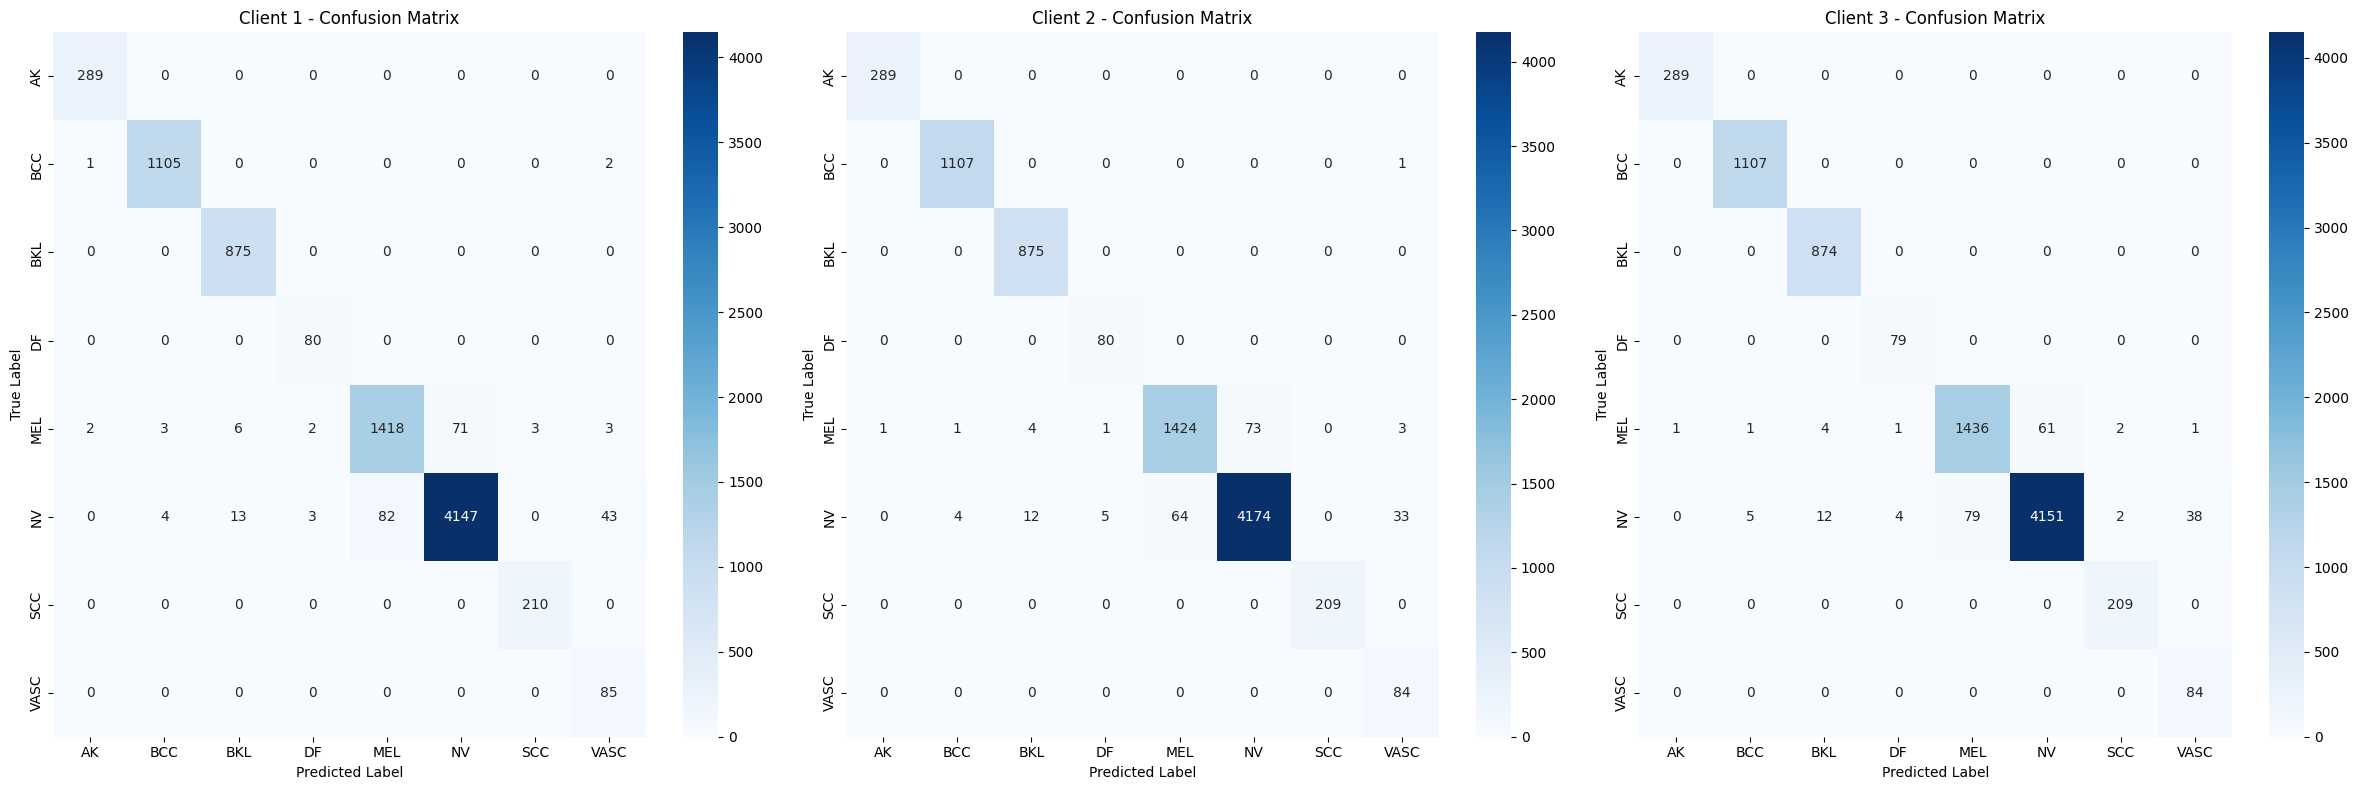

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Assuming you have a list called 'final_client_cms' where each element
# is the confusion matrix for a client (NumPy array)
# and 'all_classes' is a list of the class names.

fig, axes = plt.subplots(1, NUM_CLIENTS, figsize=(8 * NUM_CLIENTS, 8))
if NUM_CLIENTS == 1:
    axes = [axes]  # Make sure axes is iterable even for a single client

for i, cm in enumerate(final_client_cms):
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=all_classes, yticklabels=all_classes,
                ax=axes[i])
    axes[i].set_title(f'Client {i + 1} - Confusion Matrix')
    axes[i].set_xlabel('Predicted Label')
    axes[i].set_ylabel('True Label')

plt.tight_layout()
plt.show()

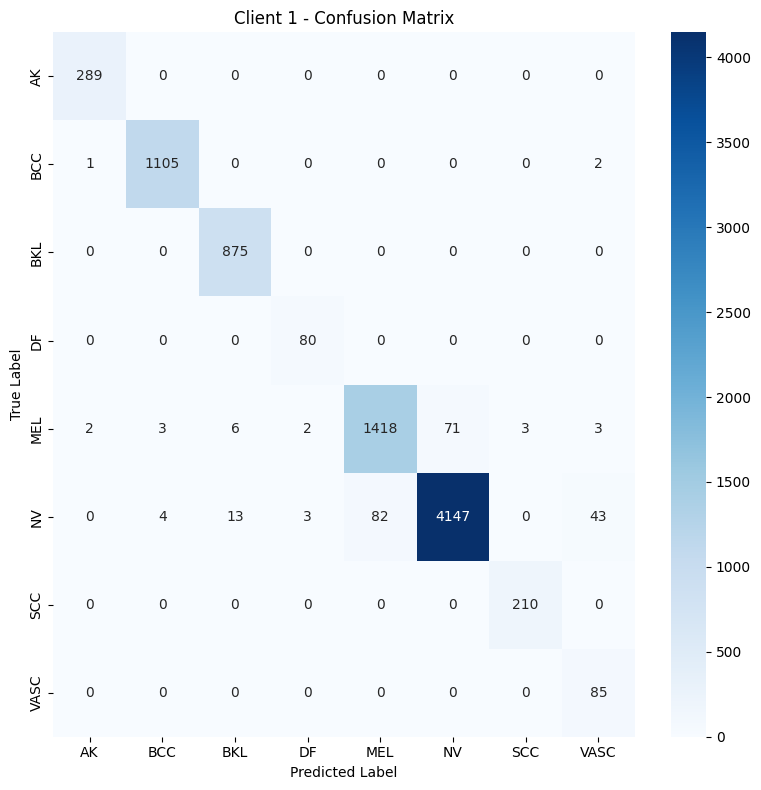

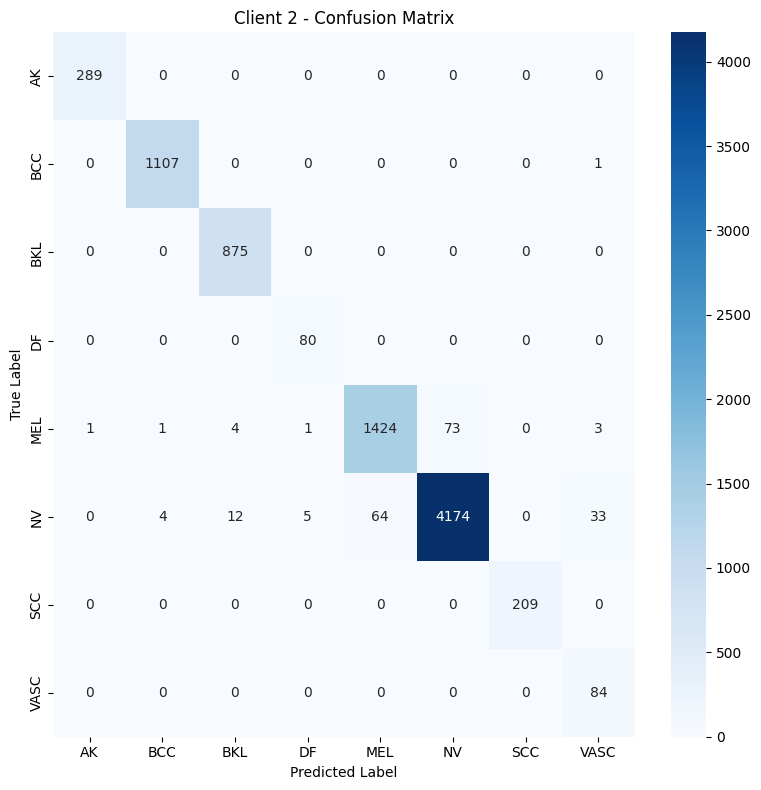

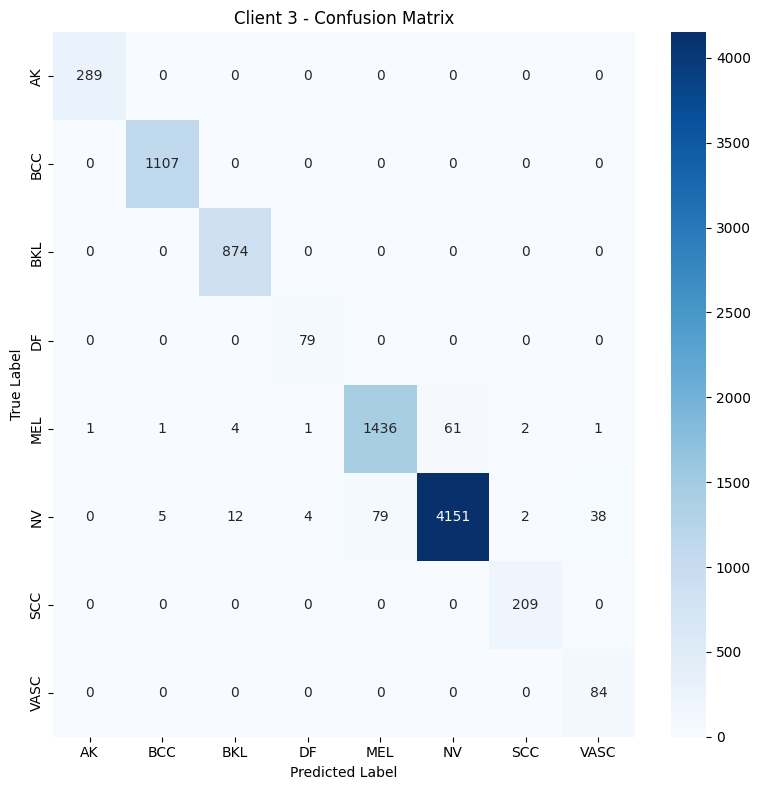

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Assuming you have a list called 'final_client_cms' where each element
# is the confusion matrix for a client (NumPy array)
# and 'all_classes' is a list of the class names.

for i, cm in enumerate(final_client_cms):
    plt.figure(figsize=(8, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=all_classes, yticklabels=all_classes)
    plt.title(f'Client {i + 1} - Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.tight_layout()
    plt.show()

In [32]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming you have lists called 'client_test_losses' and 'client_test_accuracies'
# where each element corresponds to the test loss and accuracy of a client
# after the final evaluation.

num_clients = len(client_test_losses)  # Or however you determine the number of clients

# Plotting Test Loss
plt.figure(figsize=(10, 6))
plt.plot(np.arange(1, num_clients + 1), client_test_losses, marker='o')
plt.title('Test Loss of Each Client')
plt.xlabel('Client ID')
plt.ylabel('Test Loss')
plt.xticks(np.arange(1, num_clients + 1))
plt.grid(True)
plt.tight_layout()
plt.show()

# Plotting Test Accuracy
plt.figure(figsize=(10, 6))
plt.plot(np.arange(1, num_clients + 1), client_test_accuracies, marker='o')
plt.title('Test Accuracy of Each Client')
plt.xlabel('Client ID')
plt.ylabel('Test Accuracy (%)')
plt.xticks(np.arange(1, num_clients + 1))
plt.grid(True)
plt.tight_layout()
plt.show()

NameError: name 'client_test_losses' is not defined

In [ ]:
import json
import matplotlib.pyplot as plt

# Load the training history from the JSON file
try:
    with open("fedavg_pretrained_vit_balanced_history_round_25_04_2550.json", 'r') as f:
        history = json.load(f)
except FileNotFoundError:
    print("Error: training_history.json not found.  Please ensure the file exists.")
    exit()
except json.JSONDecodeError:
    print("Error:  Invalid JSON in training_history.json.  The file may be corrupted.")
    exit()

# Check if history is a list
if not isinstance(history, list):
    print("Error: The loaded history is not a list.  Expected a list of rounds.")
    exit()

# Number of clients (assuming it's consistent across rounds)
NUM_CLIENTS = len(history[0]['client_histories'])

# Plotting code
plt.figure(figsize=(12, 6))
for client_id in range(NUM_CLIENTS):
    client_losses = [round_data['client_histories'][client_id]['train_loss'] for round_data in history]
    plt.plot(client_losses, label=f"Client {client_id + 1}")
plt.title("Client Training Loss")
plt.xlabel("Round")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(12, 6))
for client_id in range(NUM_CLIENTS):
    client_accuracies = [round_data['client_histories'][client_id]['train_accuracy'] for round_data in history]
    plt.plot(client_accuracies, label=f"Client {client_id + 1}")
plt.title("Client Training Accuracy")
plt.xlabel("Round")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.grid(True)
plt.show()
